In [1]:
import yfinance as yf
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from scipy.stats import norm
import seaborn as sns
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel
from scipy.stats import skew, kurtosis
import warnings
warnings.filterwarnings("ignore")


In [2]:
def compute_discrete(signal_u,signal_v):

    invest_u = 100
    invest_v = 100
    cumulative_invest_u = 0
    cumulative_invest_v = 0
    profit_realized_u = 0
    profit_realized_v = 0

    for i in range(0,(signal_u.shape[1])):

        if(signal_u[0][i] == 1):

            cumulative_invest_u += invest_u
            price_paid = dfx_s1['price'].iloc[i]
            stocks_purchased = invest_u/price_paid # invest/price
            while(signal_u[0][i] == 1 and i < signal_u.shape[1] - 1):
                i+=1  
            price_sold = dfx_s1['price'].iloc[i]
            profit_realized_u += (price_sold - price_paid)*(stocks_purchased)

        elif(signal_u[0][i] == -1):

            cumulative_invest_u += invest_u
            price_sold = dfx_s1['price'].iloc[i]
            stocks_sold = (invest_u/price_sold)
            while(signal_u[0][i] == -1 and i < (signal_u.shape[1])-1):
                i+=1
            price_paid = dfx_s1['price'].iloc[i]
            profit_realized_u += (price_sold - price_paid)*(stocks_sold)

    for i in range(0,(signal_v.shape[1])):

        if(signal_v[0][i] == 1):

            cumulative_invest_v += invest_v
            price_paid = dfx_s2['price'].iloc[i]
            stocks_purchased = (invest_v/price_paid)

            while(signal_v[0][i] == 1 and i < signal_u.shape[1] - 1):
                i+=1 
            price_sold = dfx_s2['price'].iloc[i]
            profit_realized_v += (price_sold - price_paid)*(stocks_purchased)

        elif(signal_v[0][i] == -1):

            cumulative_invest_v += invest_v
            price_sold = dfx_s2['price'].iloc[i]
            stocks_sold = (invest_u/price_sold)

            while(signal_v[0][i] == -1 and i < signal_u.shape[1] - 1):
                i+=1
            price_paid = dfx_s2['price'].iloc[i]
            profit_realized_v += (price_sold - price_paid)*(stocks_sold)

    if(cumulative_invest_u == 0 and cumulative_invest_v == 0):
        print("Total Investment in this Trading Period ============> ",(cumulative_invest_v + cumulative_invest_u))
        return

    print("Total Investment in this Trading Period ============> ",(cumulative_invest_v + cumulative_invest_u))
    print("Total Profit/Loss Realized in this Trading Period ==========> ",(profit_realized_u + profit_realized_v))
    res.append(profit_realized_u + profit_realized_v)

    print("Percentage terms =======> ",((profit_realized_u + profit_realized_v)/(cumulative_invest_u + cumulative_invest_v)) + 1)



    

In [3]:
def signal_generation(p_u,p_v):

    signal_u = np.zeros((1,len(p_u)))
    signal_v = np.zeros((1,len(p_v)))

    for i in range(0,len(p_u)):

        if(p_u[i] >= 0.7 and p_v[i] <= 0.3):

            signal_u[0][i] = -1
            signal_v[0][i] = 1

            while(p_v[i] < 0.5 and p_u[i] > 0.5 and i < len(p_u)-1):

                signal_u[0][i] = -1
                signal_v[0][i] = 1
                i+=1

        elif(p_u[i] <= 0.3 and p_v[i] >= 0.7 ):

            signal_u[0][i] = 1
            signal_v[0][i] = -1

            while(p_v[i] > 0.5 and p_u[i] < 0.5 and i < len(p_u)-1):

                signal_u[0][i] = -1
                signal_v[0][i] = 1
                i+=1

    compute_discrete((signal_u),(signal_v))

In [4]:
from sklearn.gaussian_process.kernels import Matern

def Rolling_Window(stocks_2D):

    positions_per_window = []

    for i in range(0,len(stocks_2D) - (trading_period + formation_period),trading_period):

    
        X = stocks_2D[i : i + formation_period, :, :].reshape(formation_period, -1)
        Y = stocks_2D[i + 1 : i + formation_period + 1, :, :].reshape(formation_period, -1)
        X = X[:, ~np.all(np.isnan(X), axis=0)]
        Y = Y[:, ~np.all(np.isnan(Y), axis=0)]
        X = np.where(np.isnan(X), np.nanmean(X, axis=0), X)
        Y = np.where(np.isnan(Y), np.nanmean(Y, axis=0), Y)

        kernel = 63*RBF(length_scale=1) + 0.063**2*RationalQuadratic(length_scale=1.2, alpha=0.78) + 0.18**2 * RBF(length_scale=0.134) + WhiteKernel(noise_level=0.19**2)
        gaussian_process = GaussianProcessRegressor(kernel=kernel,alpha = 1e-10,n_restarts_optimizer=10,normalize_y=False)

        gaussian_process.fit(X, Y)
        kernel_upd = gaussian_process.kernel_
        kernel_upd += WhiteKernel(noise_level=1e-6)  

        probabilities = []
        Prob_U = []
        Prob_V = []
        positions = 0

        for j in range(i+formation_period, i+formation_period+trading_period):
            
            if np.isnan(stocks_2D[j - 1]).any():
                stocks_2D[j - 1] = np.nan_to_num(stocks_2D[j - 1], nan=np.nanmean(stocks_2D[j - 1]))
            if np.isnan(stocks_2D[j]).any():
                stocks_2D[j] = np.nan_to_num(stocks_2D[j], nan=np.nanmean(stocks_2D[j]))

            kernel_matrix = kernel_upd(stocks_2D[j - 1]) 

            bivariate_mean_U = (kernel_matrix[0,1]) * (1/kernel_matrix[0,0]) * stocks_2D[j-1, 1].mean()
            bivariate_mean_V = (kernel_matrix[0,1]) * (1/kernel_matrix[0,0]) * stocks_2D[j-1, 0].mean()

            bivariate_std_dev = kernel_matrix[0][0] - ((kernel_matrix[0][1]) * (1/kernel_matrix[1][1]) * (kernel_matrix[1][0]))

            conditional_probability_U = norm.cdf((stocks_2D[j, 0][0] - bivariate_mean_U) / bivariate_std_dev)

            conditional_probability_V = norm.cdf(
                (stocks_2D[j, 1][0] - bivariate_mean_V) / bivariate_std_dev
            )

            Prob_U.append(np.round(conditional_probability_U,3))
            Prob_V.append(np.round(conditional_probability_V,3))

            if((conditional_probability_U >= 0.7 and conditional_probability_V <= 0.3) or (conditional_probability_U <= 0.3 and conditional_probability_V >= 0.7)):

                positions = positions + 1

            probabilities.append([conditional_probability_U , conditional_probability_V])

        probabilities = np.array(probabilities)
        signal_generation(np.asarray(Prob_U),np.asarray(Prob_V))
        positions_per_window.append(positions)
        dataframe_columns = ['Conditional_Probability_U','Conditional_Probability_V']
        probabilities_df = pd.DataFrame(probabilities,columns=dataframe_columns)

    positions_per_window = np.array(positions_per_window)
    positions_df = pd.DataFrame(positions_per_window)
    print(positions_df)

In [5]:
dfx = pd.read_csv(r"merged_sp500_data.csv")
dfx = dfx[['permno', 'DATE', 'mvel1', 'indmom', 'baspread', 'maxret', 'zerotrade',
       'sic2', 'return','price']]
feature_list = dfx.columns[2:]
formation_period = 12
trading_period = 8
dfx_s1 = dfx[dfx['permno'] == 28388]
dfx_s2 = dfx[dfx['permno'] == 85058]

In [11]:
def evaluate_result(res,F,T):
    returns = np.array(res)

    mean_return = np.mean(returns) if len(returns) > 0 else np.nan
    std_dev = np.std(returns, ddof=1) if len(returns) > 1 else np.nan
    sharpe_ratio = mean_return / std_dev if std_dev != 0 else np.nan
    downside_returns = returns[returns < 0]
    sortino_ratio = mean_return / np.std(downside_returns, ddof=1) if len(downside_returns) > 0 else np.nan

    if len(returns) > 0:
        cumulative_returns = np.cumsum(returns)  
        rolling_max = np.maximum.accumulate(cumulative_returns)  
        drawdowns = (rolling_max - cumulative_returns)  
        max_drawdown = np.max(drawdowns) 
    else:
        max_drawdown = np.nan

    VaR_95 = np.percentile(returns, 5) if len(returns) > 0 else np.nan
    CVaR_95 = np.mean(returns[returns <= VaR_95]) if len(returns) > 0 else np.nan
    skewness = skew(returns) if len(returns) > 0 else np.nan
    kurt = kurtosis(returns) if len(returns) > 0 else np.nan
    metrics = {
        "Mean Return": mean_return,
        "Std Dev": std_dev,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown,
        "VaR 95%": VaR_95,
        "CVaR 95%": CVaR_95,
        "Skewness": skewness,
        "Kurtosis": kurt
        }
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")
    
    cumulative_returns = np.cumsum(returns)
    rolling_max = np.maximum.accumulate(cumulative_returns)
    drawdowns = rolling_max - cumulative_returns 
    max_drawdown = np.max(drawdowns)

    sns.set_style("whitegrid")
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_returns, label="Cumulative Returns", color="blue", linewidth=2)
    plt.fill_between(range(len(cumulative_returns)), cumulative_returns, rolling_max, color='red', alpha=0.3, label="Drawdown")
    plt.axhline(y=VaR_95, color='purple', linestyle="dotted", linewidth=1.5, label="VaR 95%")
    plt.annotate(f"Max Drawdown: {max_drawdown:.4f}", xy=(np.argmax(drawdowns), np.min(cumulative_returns)),
                xytext=(-50, -30), textcoords='offset points', arrowprops=dict(arrowstyle="->", color="red"), fontsize=10, color="red")

    plt.xlabel("Trade Number")
    plt.ylabel("Cumulative PnL")
    plt.title(f"Strategy Performance with Risk Metrics for fomration period - {F} and Trading Period - {T}")
    plt.legend()
    plt.show()
    
    return metrics
    
    

In [ ]:
net_results = {}


Running for formation - 27 and Trading - 4
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  200
Total Profit/Loss Realized in this Trading Period ==========>  0.0
Percentage terms =======>  1.0
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  400
Total Profit/Loss Realized in this Trading Period ==========>  -5.598707009388256
Percentage terms =======>  0.9860032324765293
Total Investment in this Trading Period ============>  800
Total Profit/Loss Realized in this Trading Period ==========>  -23.694878430739244
Percentage terms =======>  0.970381401961576
Total Investment in this Trading Period ============>  400
Total Profit/Loss Realized in this Trading Period ==========>  -4.873721202648184
Percentage terms =======>  0.9878156969933796
Total

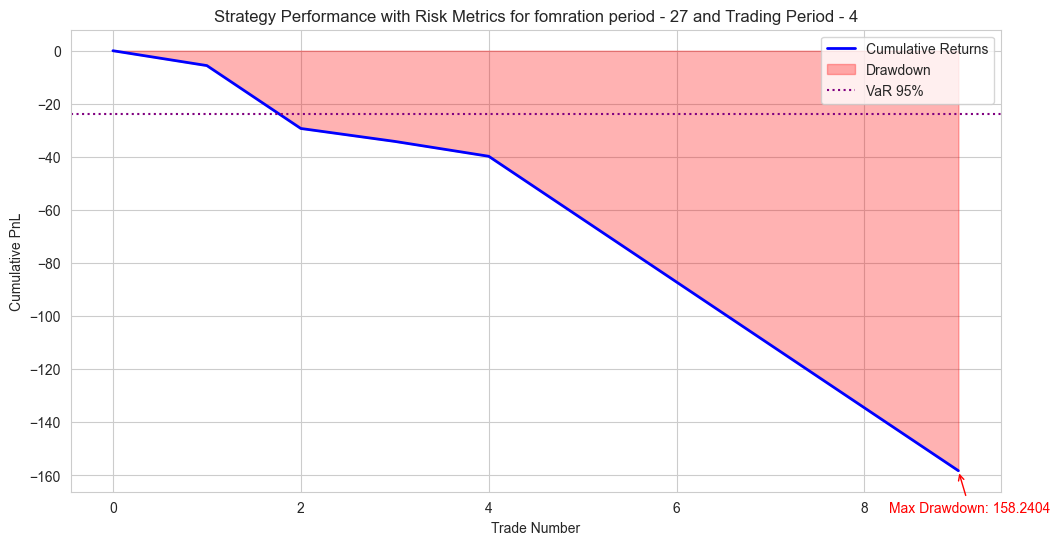

Running for formation - 27 and Trading - 5
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  600
Total Profit/Loss Realized in this Trading Period ==========>  3.088701824247386
Percentage terms =======>  1.0051478363737456
Total Investment in this Trading Period ============>  1000
Total Profit/Loss Realized in this Trading Period ==========>  -4.122118272415435
Percentage terms =======>  0.9958778817275845
Total Investment in this Trading Period ============>  200
Total Profit/Loss Realized in this Trading Period ==========>  0.0
Percentage terms =======>  1.0
Total Investment in this Trading Period ============>  800
Total Profit/Loss Realized in this Trading Period ==========>  -2.228807214760561
Percentage terms =======>  0.9972139909815493
Total

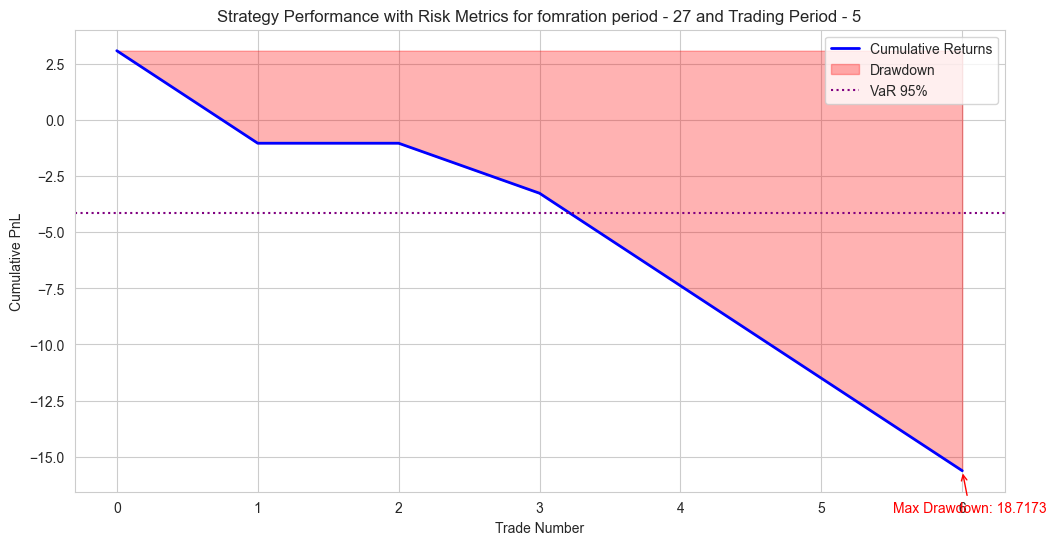

Running for formation - 27 and Trading - 6
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  400
Total Profit/Loss Realized in this Trading Period ==========>  -0.8749236887059393
Percentage terms =======>  0.9978126907782352
Total Investment in this Trading Period ============>  1200
Total Profit/Loss Realized in this Trading Period ==========>  -8.507915540565113
Percentage terms =======>  0.9929100703828624
Total Investment in this Trading Period ============>  200
Total Profit/Loss Realized in this Trading Period ==========>  -0.8749236887059393
Percentage terms =======>  0.9956253815564703
Total Investment in this Trading Period ============>  1000
Total Profit/Loss Realized in this Trading Period ==========>  -8.507915540565113
Percentage terms =======>  0.9914920844594349
Total Investment in this Tra

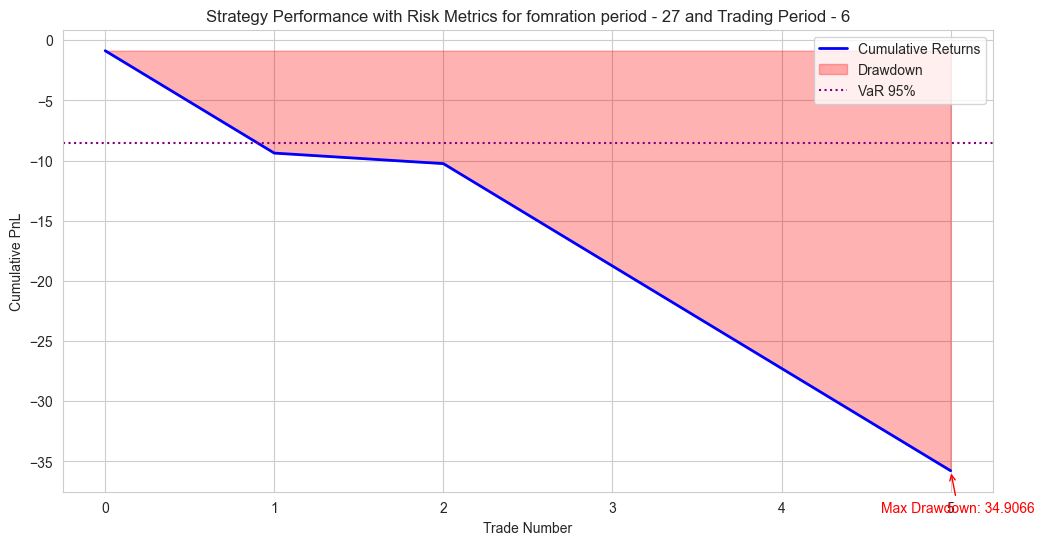

Running for formation - 27 and Trading - 7
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  1200
Total Profit/Loss Realized in this Trading Period ==========>  -0.05081135372247303
Percentage terms =======>  0.9999576572052312
Total Investment in this Trading Period ============>  600
Total Profit/Loss Realized in this Trading Period ==========>  -4.873721202648184
Percentage terms =======>  0.9918771313289196
Total Investment in this Trading Period ============>  1000
Total Profit/Loss Realized in this Trading Period ==========>  -0.05081135372247303
Percentage terms =======>  0.9999491886462776
Total Investment in this Trading Period ============>  1400
Total Profit/Loss Realized in this Trading Period ==========>  -1.7822276874205016
Percentage terms =======>  0.9987269802232711
Total Investment in this

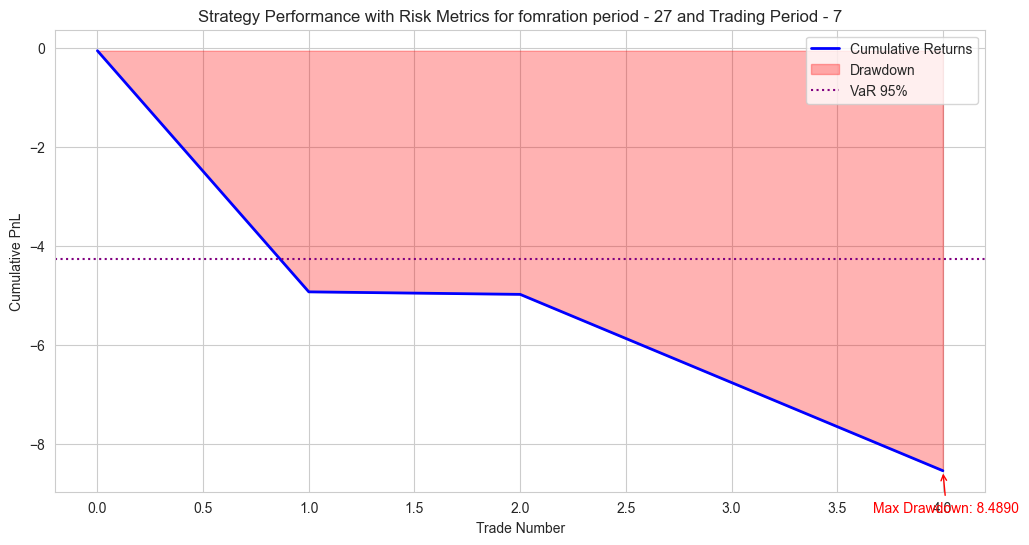

Running for formation - 27 and Trading - 8
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  800
Total Profit/Loss Realized in this Trading Period ==========>  12.24754436426011
Percentage terms =======>  1.0153094304553252
Total Investment in this Trading Period ============>  200
Total Profit/Loss Realized in this Trading Period ==========>  1.4672974745274825
Percentage terms =======>  1.0073364873726374
Total Investment in this Trading Period ============>  1200
Total Profit/Loss Realized in this Trading Period ==========>  -1.7822276874205016
Percentage terms =======>  0.9985148102604829
Total Investment in this Trading Period ============>  1200
Total Profit/Loss Realized in this Trading Period ==========>  13.067278695017265
Percentage terms =======>  1.0108893989125143
Total Investment in this Trading Period ============>  1600
Total Profit/Loss Realized in this Trading Period ==========>  9.71213259286857
Perc

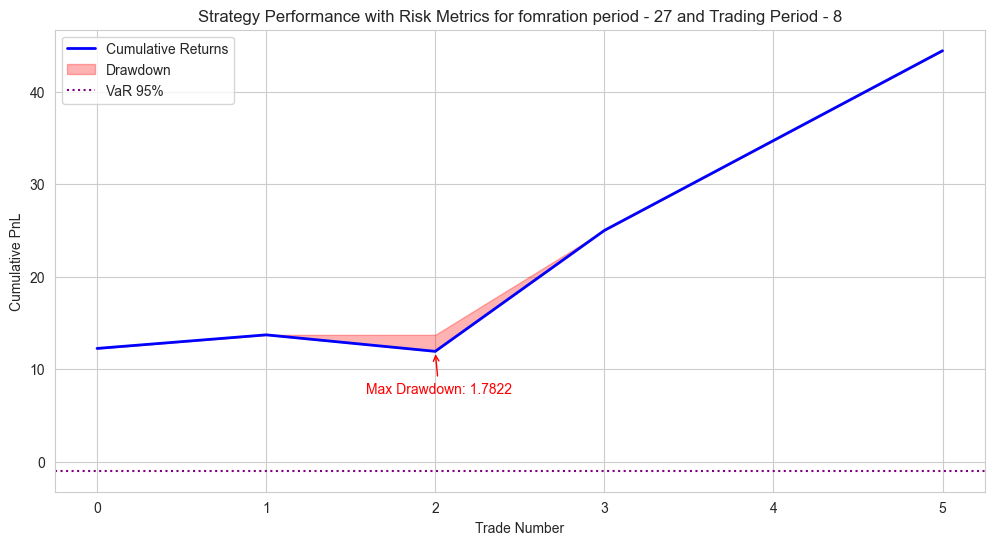

Running for formation - 27 and Trading - 9
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  1000
Total Profit/Loss Realized in this Trading Period ==========>  -7.673070225207869
Percentage terms =======>  0.9923269297747921
Total Investment in this Trading Period ============>  800
Total Profit/Loss Realized in this Trading Period ==========>  -27.096290281222466
Percentage terms =======>  0.9661296371484719
Total Investment in this Trading Period ============>  1800
Total Profit/Loss Realized in this Trading Period ==========>  -19.551340435069434
Percentage terms =======>  0.9891381442027392
Total Investment in this Trading Period ============>  1800
Total Profit/Loss Realized in this Trading Period ==========>  -19.551340435069434
Percentage terms =======>  0.9891381442027392
   0
0  0
1  0
2  5
3  4
4  8
5  9
-73.8720413765692
Mean Return: -18.4680
Std Dev:

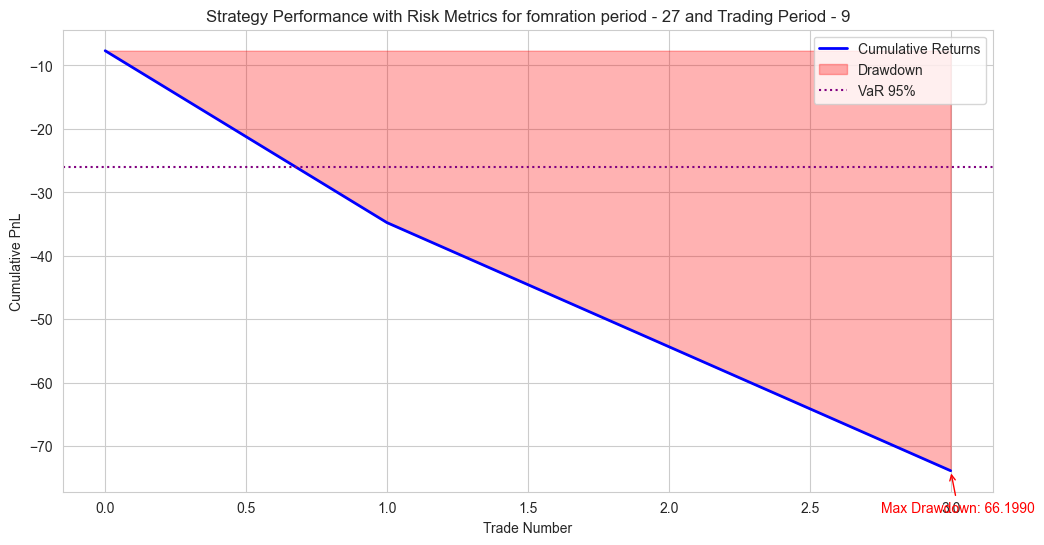

Running for formation - 27 and Trading - 10
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  1600
Total Profit/Loss Realized in this Trading Period ==========>  3.467292560582507
Percentage terms =======>  1.002167057850364
Total Investment in this Trading Period ============>  1000
Total Profit/Loss Realized in this Trading Period ==========>  -1.6115387514646473
Percentage terms =======>  0.9983884612485353
Total Investment in this Trading Period ============>  2000
Total Profit/Loss Realized in this Trading Period ==========>  -4.870894416418082
Percentage terms =======>  0.9975645527917909
    0
0   0
1   0
2   8
3   5
4  10
-3.0151406073002223
Mean Return: -1.0050
Std Dev: 4.2020
Sharpe Ratio: -0.2392
Sortino Ratio: -0.4361
Max Drawdown: 6.4824
VaR 95%: -4.5450
CVaR 95%: -4.8709
Skewness: 0.2596
Kurtosis: -1.5000


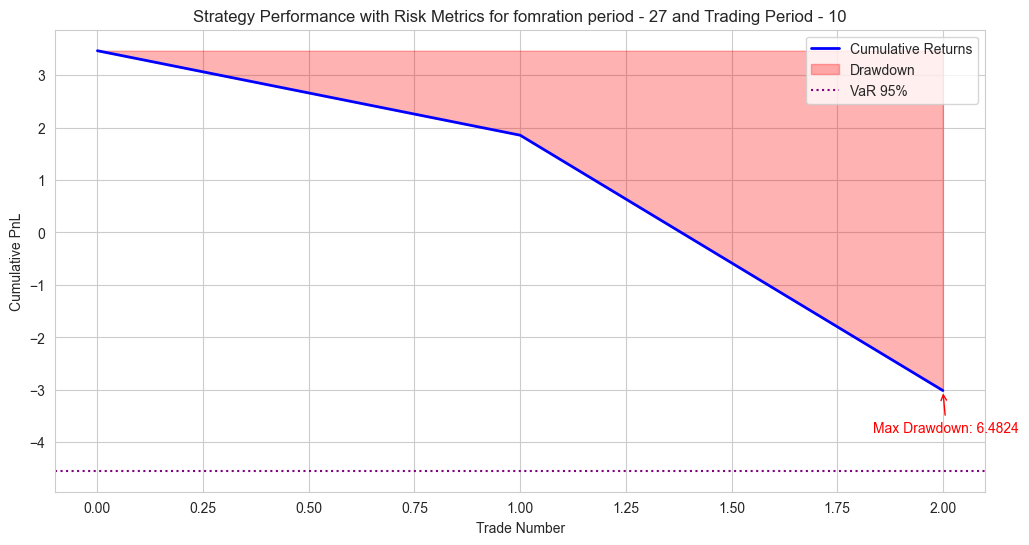

Running for formation - 27 and Trading - 11
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  1600
Total Profit/Loss Realized in this Trading Period ==========>  -19.551340435069434
Percentage terms =======>  0.9877804122280816
Total Investment in this Trading Period ============>  1800
Total Profit/Loss Realized in this Trading Period ==========>  29.56977482301489
Percentage terms =======>  1.0164276526794527
Total Investment in this Trading Period ============>  2200
Total Profit/Loss Realized in this Trading Period ==========>  39.296454927978566
Percentage terms =======>  1.017862024967263
    0
0   0
1   0
2   7
3   8
4  11
49.31488931592402
Mean Return: 16.4383
Std Dev: 31.5451
Sharpe Ratio: 0.5211
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: -14.6392
CVaR 95%: -19.5513
Skewness: -0.6322
Kurtosis: -1.5000


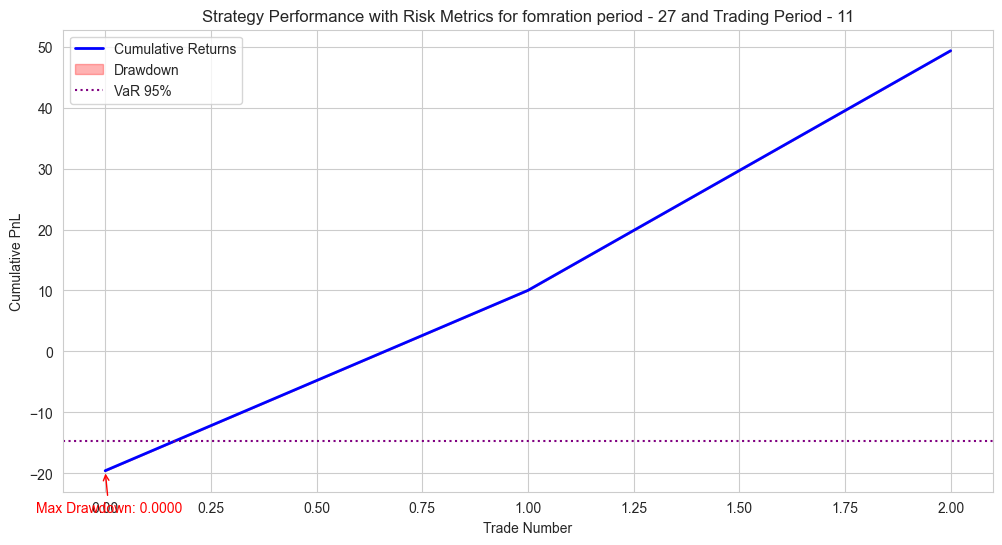

Running for formation - 27 and Trading - 12
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  1200
Total Profit/Loss Realized in this Trading Period ==========>  -1.7822276874205016
Percentage terms =======>  0.9985148102604829
Total Investment in this Trading Period ============>  2400
Total Profit/Loss Realized in this Trading Period ==========>  47.33303270286294
Percentage terms =======>  1.0197220969595262
    0
0   0
1   0
2   5
3  11
45.550805015442435
Mean Return: 22.7754
Std Dev: 34.7297
Sharpe Ratio: 0.6558
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: 0.6735
CVaR 95%: -1.7822
Skewness: 0.0000
Kurtosis: -2.0000


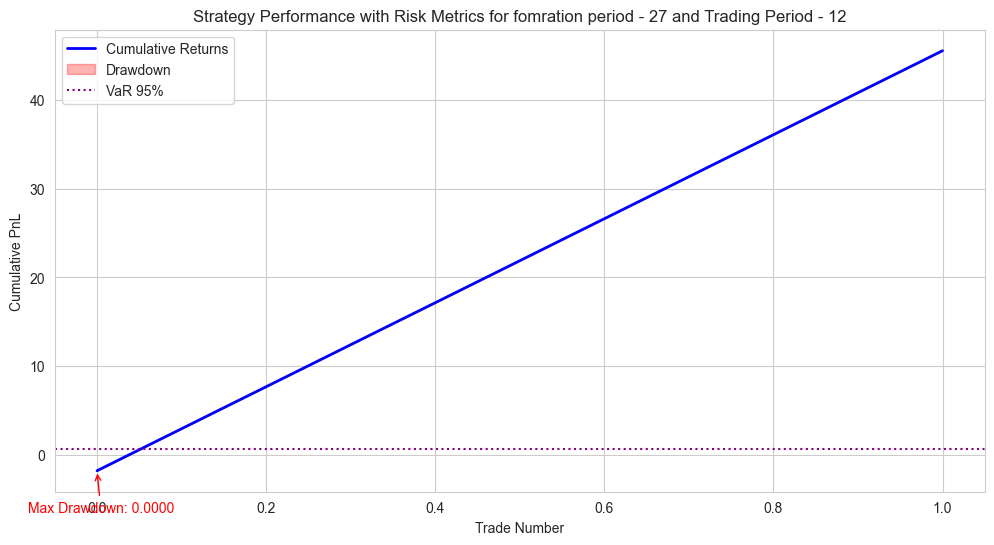

Running for formation - 27 and Trading - 13
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  1400
Total Profit/Loss Realized in this Trading Period ==========>  4.404249636285087
Percentage terms =======>  1.0031458925973464
Total Investment in this Trading Period ============>  2600
Total Profit/Loss Realized in this Trading Period ==========>  101.92472747475307
Percentage terms =======>  1.0392018182595204
    0
0   0
1   0
2   7
3  13
106.32897711103816
Mean Return: 53.1645
Std Dev: 68.9574
Sharpe Ratio: 0.7710
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: 9.2803
CVaR 95%: 4.4042
Skewness: 0.0000
Kurtosis: -2.0000


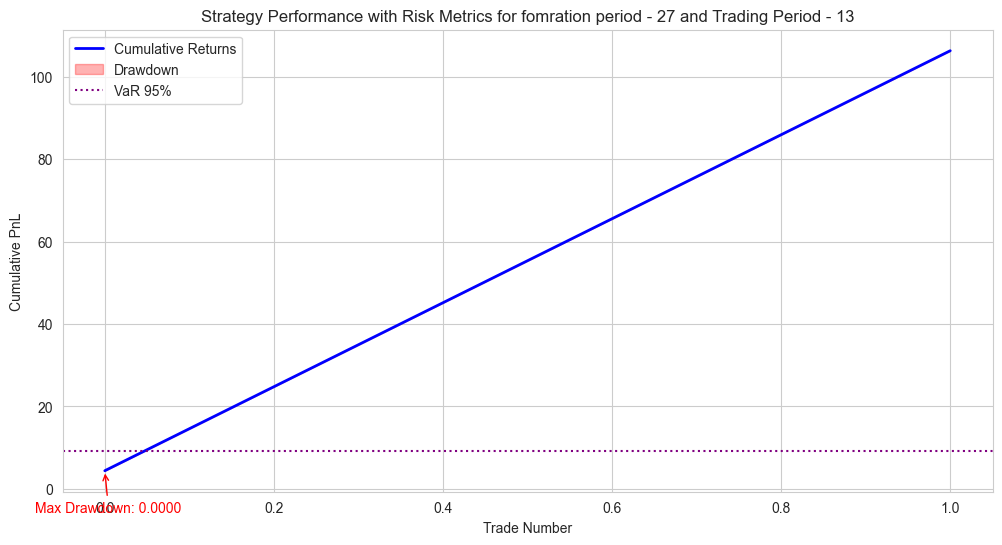

Running for formation - 27 and Trading - 14
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  1600
Total Profit/Loss Realized in this Trading Period ==========>  2.5240919056335116
Percentage terms =======>  1.0015775574410208
Total Investment in this Trading Period ============>  2800
Total Profit/Loss Realized in this Trading Period ==========>  40.774706083670054
Percentage terms =======>  1.014562395029882
    0
0   0
1   0
2   8
3  14
43.298797989303566
Mean Return: 21.6494
Std Dev: 27.0473
Sharpe Ratio: 0.8004
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: 4.4366
CVaR 95%: 2.5241
Skewness: 0.0000
Kurtosis: -2.0000


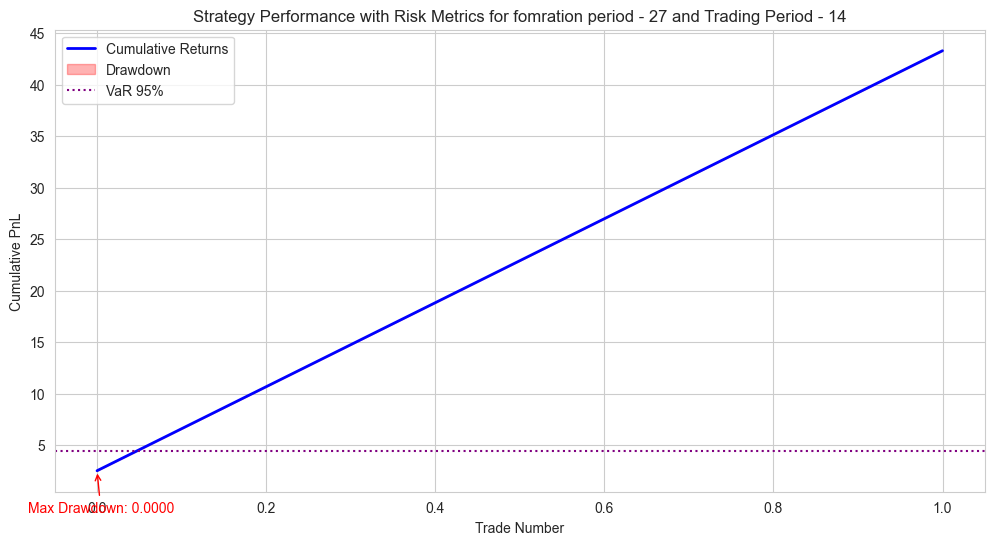

Running for formation - 27 and Trading - 15
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  1800
Total Profit/Loss Realized in this Trading Period ==========>  56.9417192436352
Percentage terms =======>  1.0316342884686862
   0
0  0
1  0
2  8
56.9417192436352
Mean Return: 56.9417
Std Dev: nan
Sharpe Ratio: nan
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: 56.9417
CVaR 95%: 56.9417
Skewness: nan
Kurtosis: nan


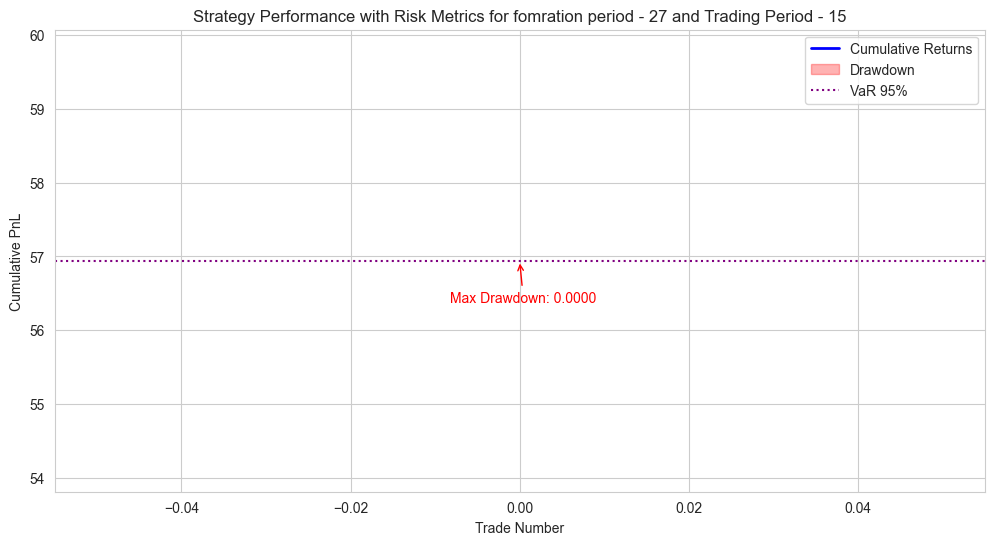

Running for formation - 27 and Trading - 16
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  1600
Total Profit/Loss Realized in this Trading Period ==========>  57.81664293234114
Percentage terms =======>  1.0361354018327131
Total Investment in this Trading Period ============>  2800
Total Profit/Loss Realized in this Trading Period ==========>  114.3705385323091
Percentage terms =======>  1.040846620904396
    0
0   0
1   1
2  11
172.18718146465022
Mean Return: 86.0936
Std Dev: 39.9896
Sharpe Ratio: 2.1529
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: 60.6443
CVaR 95%: 57.8166
Skewness: 0.0000
Kurtosis: -2.0000


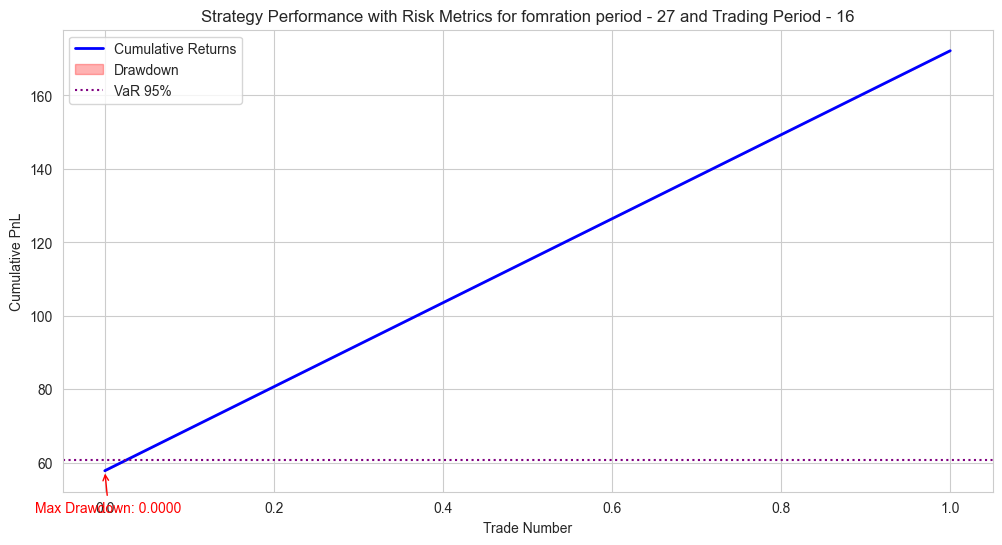

Running for formation - 27 and Trading - 17
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  3400
Total Profit/Loss Realized in this Trading Period ==========>  173.97353047862333
Percentage terms =======>  1.0511686854348892
    0
0   0
1   0
2  15
173.97353047862333
Mean Return: 173.9735
Std Dev: nan
Sharpe Ratio: nan
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: 173.9735
CVaR 95%: 173.9735
Skewness: nan
Kurtosis: nan


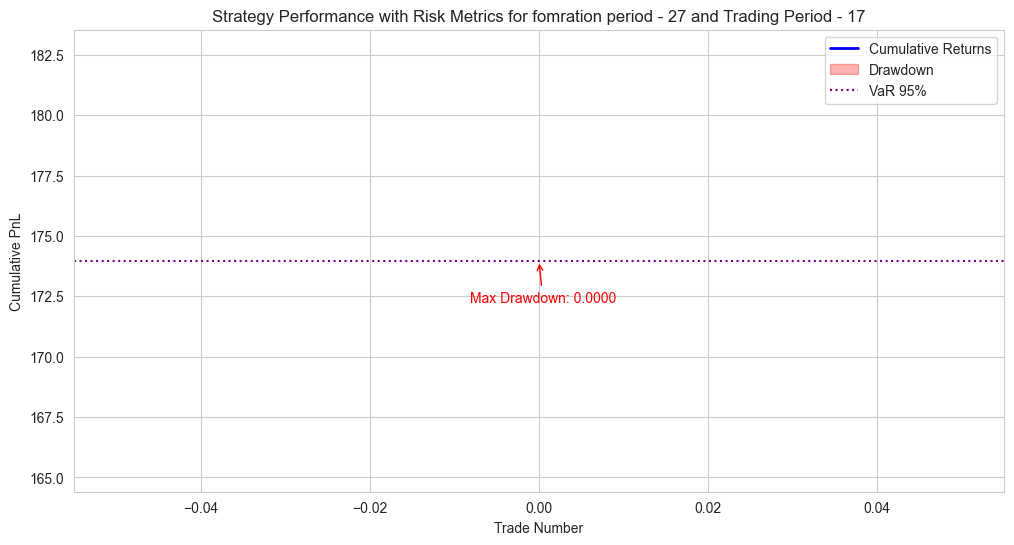

Running for formation - 27 and Trading - 18
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  2600
Total Profit/Loss Realized in this Trading Period ==========>  90.20278709826218
Percentage terms =======>  1.0346933796531776
Total Investment in this Trading Period ============>  3600
Total Profit/Loss Realized in this Trading Period ==========>  237.34539727091604
Percentage terms =======>  1.0659292770196989
    0
0   0
1  11
2  17
327.5481843691782
Mean Return: 163.7741
Std Dev: 104.0455
Sharpe Ratio: 1.5741
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: 97.5599
CVaR 95%: 90.2028
Skewness: 0.0000
Kurtosis: -2.0000


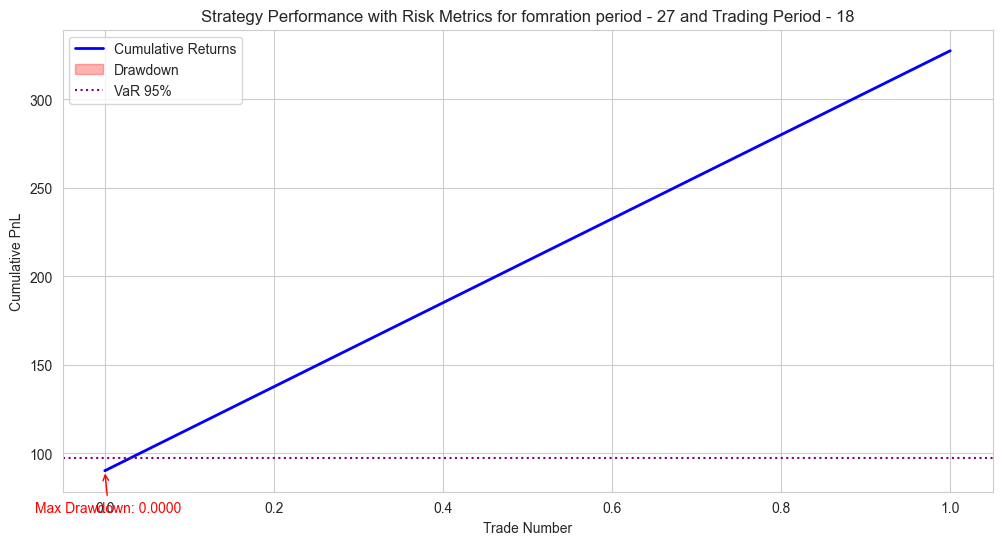

Running for formation - 27 and Trading - 19
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  3000
Total Profit/Loss Realized in this Trading Period ==========>  107.87717629896869
Percentage terms =======>  1.035959058766323
    0
0   0
1  13
107.87717629896869
Mean Return: 107.8772
Std Dev: nan
Sharpe Ratio: nan
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: 107.8772
CVaR 95%: 107.8772
Skewness: nan
Kurtosis: nan


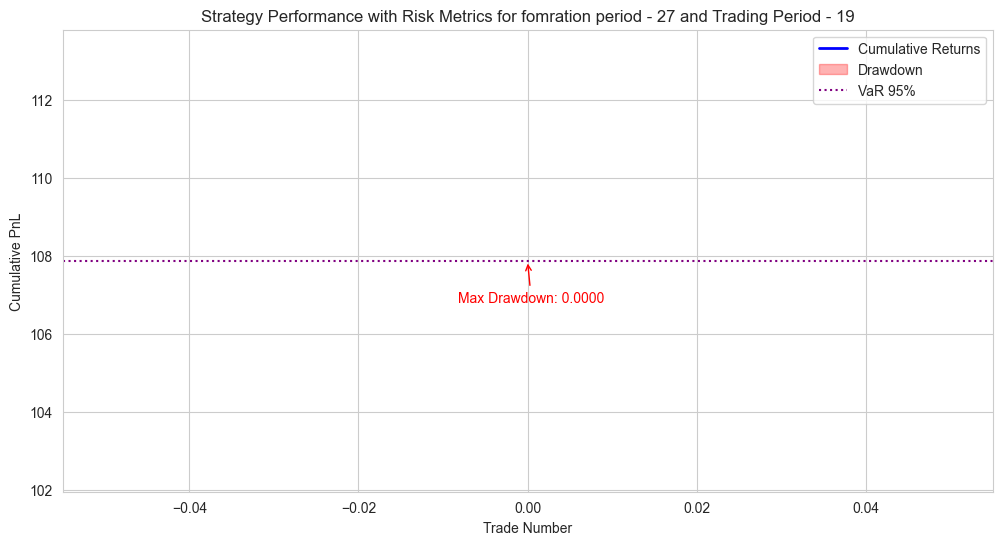

Running for formation - 27 and Trading - 20
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  3400
Total Profit/Loss Realized in this Trading Period ==========>  80.96811758893013
Percentage terms =======>  1.0238141522320383
    0
0   0
1  14
80.96811758893013
Mean Return: 80.9681
Std Dev: nan
Sharpe Ratio: nan
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: 80.9681
CVaR 95%: 80.9681
Skewness: nan
Kurtosis: nan


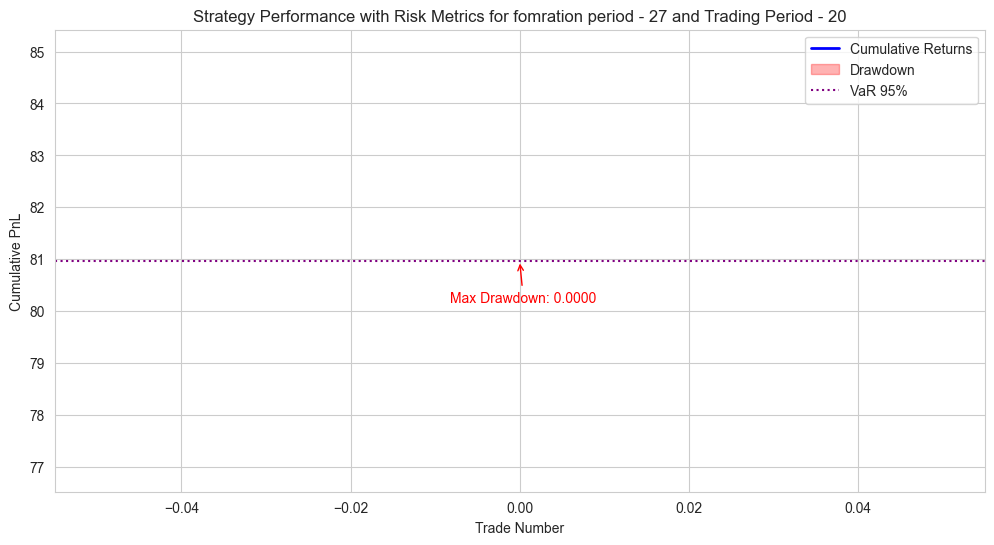

Running for formation - 27 and Trading - 21
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  3200
Total Profit/Loss Realized in this Trading Period ==========>  39.06233122624689
Percentage terms =======>  1.0122069785082022
    0
0   0
1  15
39.06233122624689
Mean Return: 39.0623
Std Dev: nan
Sharpe Ratio: nan
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: 39.0623
CVaR 95%: 39.0623
Skewness: nan
Kurtosis: nan


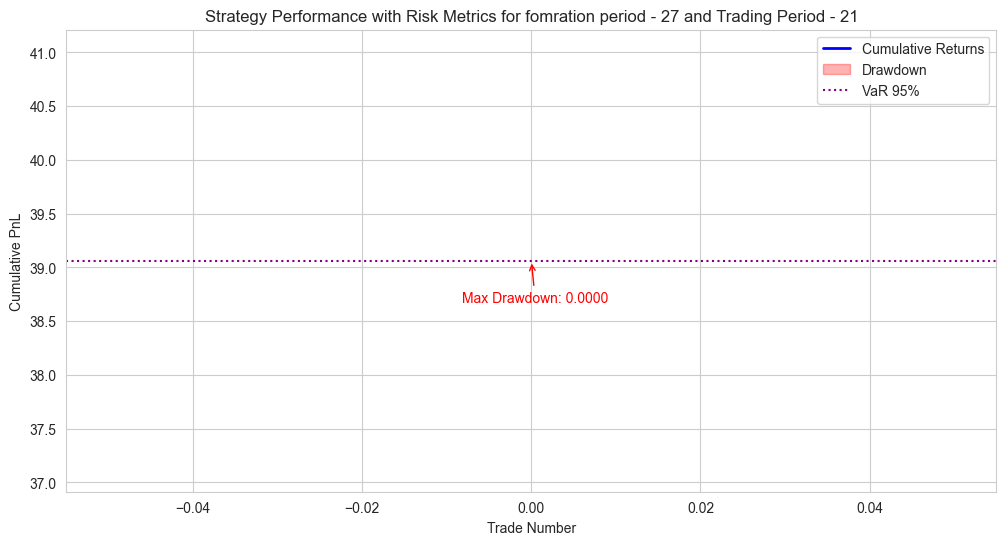

Running for formation - 27 and Trading - 22
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  3600
Total Profit/Loss Realized in this Trading Period ==========>  38.47952283285116
Percentage terms =======>  1.0106887563424587
    0
0   0
1  15
38.47952283285116
Mean Return: 38.4795
Std Dev: nan
Sharpe Ratio: nan
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: 38.4795
CVaR 95%: 38.4795
Skewness: nan
Kurtosis: nan


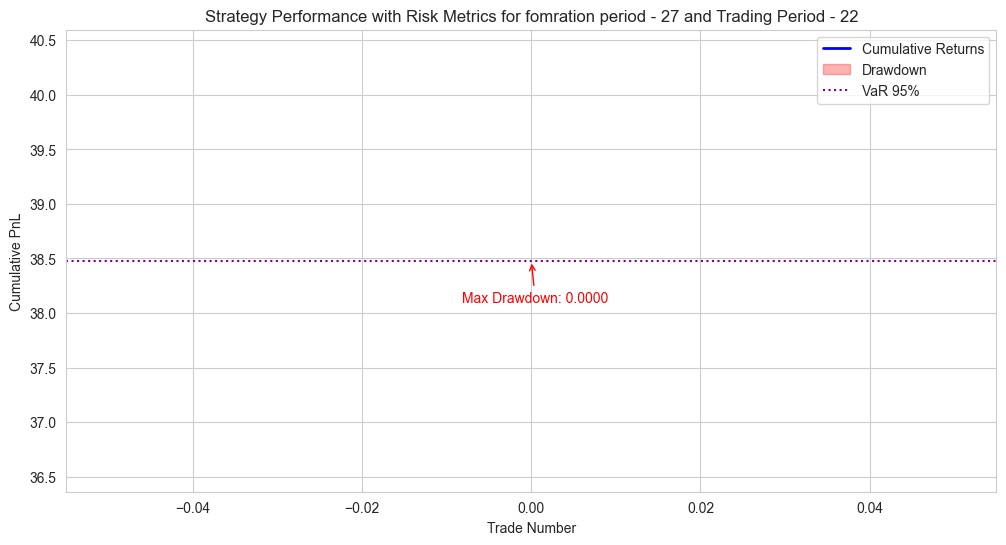

Running for formation - 27 and Trading - 23
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  2600
Total Profit/Loss Realized in this Trading Period ==========>  38.31915011052966
Percentage terms =======>  1.014738134657896
    0
0   0
1  12
38.31915011052966
Mean Return: 38.3192
Std Dev: nan
Sharpe Ratio: nan
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: 38.3192
CVaR 95%: 38.3192
Skewness: nan
Kurtosis: nan


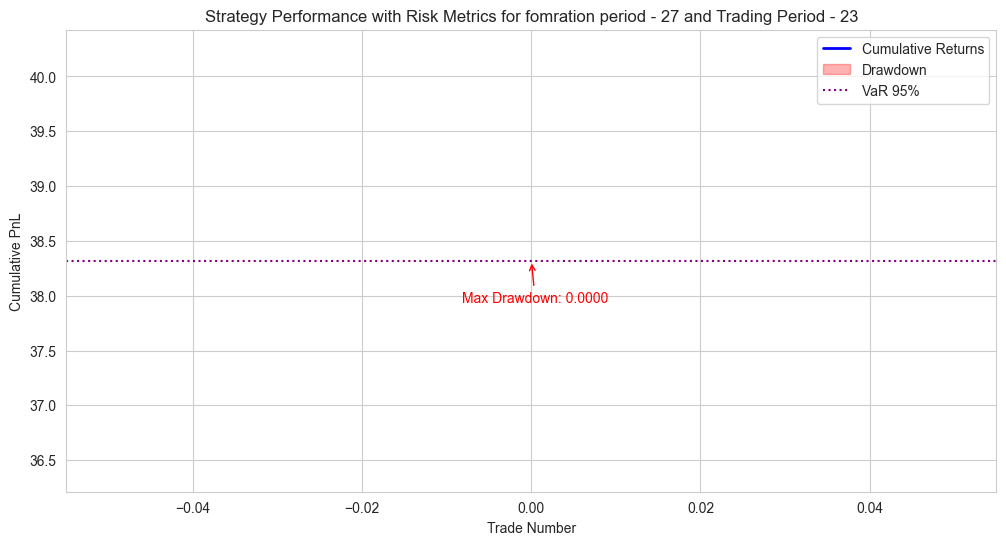

Running for formation - 27 and Trading - 24
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  3000
Total Profit/Loss Realized in this Trading Period ==========>  37.211058294373615
Percentage terms =======>  1.0124036860981245
    0
0   0
1  14
37.211058294373615
Mean Return: 37.2111
Std Dev: nan
Sharpe Ratio: nan
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: 37.2111
CVaR 95%: 37.2111
Skewness: nan
Kurtosis: nan


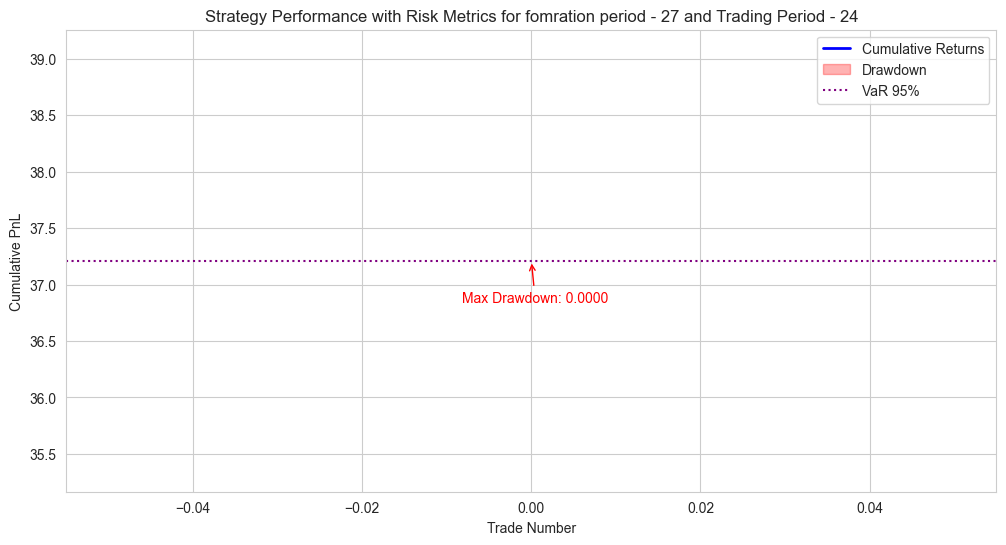

Running for formation - 27 and Trading - 25
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  3400
Total Profit/Loss Realized in this Trading Period ==========>  40.51952731374274
Percentage terms =======>  1.0119175080334537
    0
0   0
1  17
40.51952731374274
Mean Return: 40.5195
Std Dev: nan
Sharpe Ratio: nan
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: 40.5195
CVaR 95%: 40.5195
Skewness: nan
Kurtosis: nan


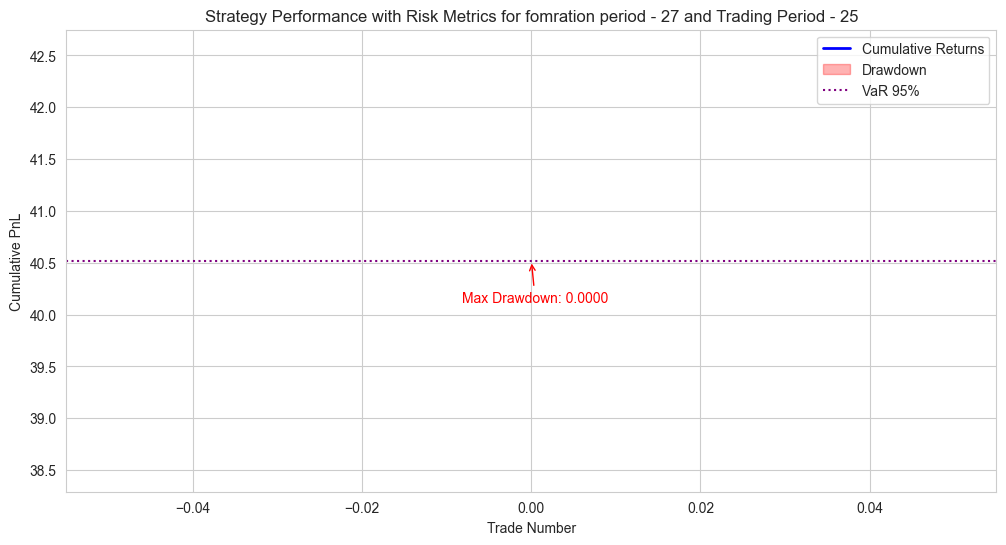

Running for formation - 27 and Trading - 26
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  3600
Total Profit/Loss Realized in this Trading Period ==========>  17.76728635563343
Percentage terms =======>  1.0049353573210094
    0
0   0
1  18
17.76728635563343
Mean Return: 17.7673
Std Dev: nan
Sharpe Ratio: nan
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: 17.7673
CVaR 95%: 17.7673
Skewness: nan
Kurtosis: nan


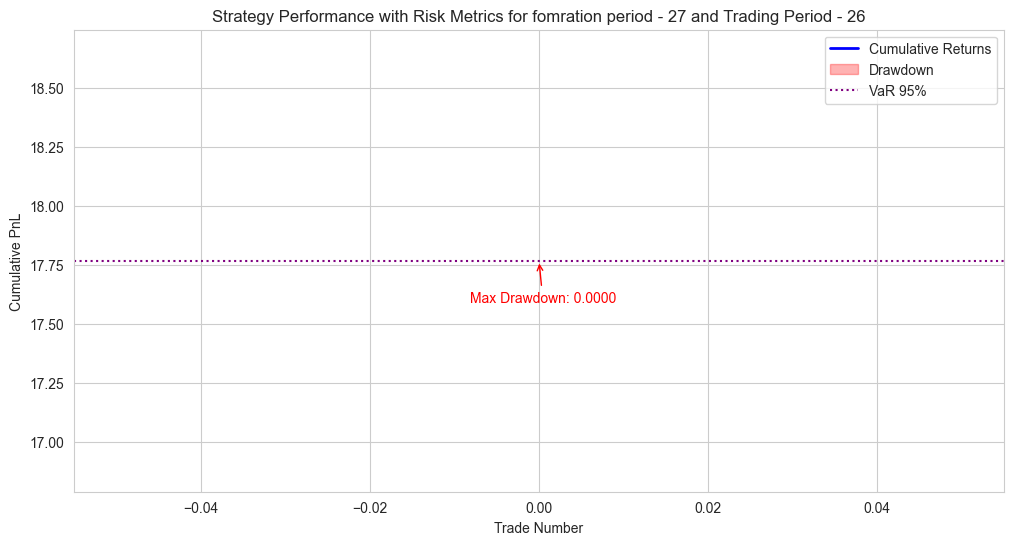

Running for formation - 27 and Trading - 27
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  4400
Total Profit/Loss Realized in this Trading Period ==========>  42.37628963611871
Percentage terms =======>  1.0096309749172998
    0
0   0
1  21
42.37628963611871
Mean Return: 42.3763
Std Dev: nan
Sharpe Ratio: nan
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: 42.3763
CVaR 95%: 42.3763
Skewness: nan
Kurtosis: nan


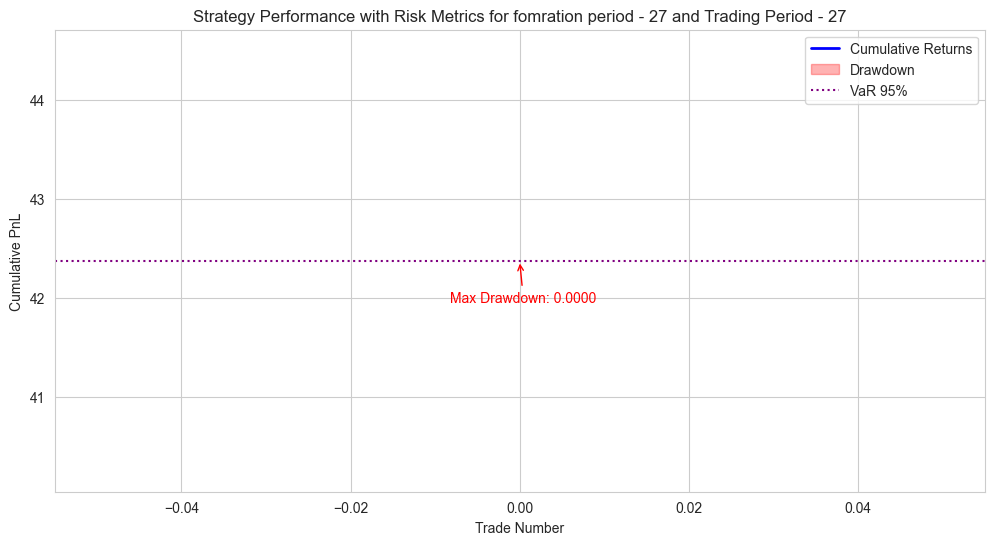

Running for formation - 28 and Trading - 4
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  600
Total Profit/Loss Realized in this Trading Period ==========>  -16.364976029617445
Percentage terms =======>  0.9727250399506376
Total Investment in this Trading Period ============>  800
Total Profit/Loss Realized in this Trading Period ==========>  -23.694878430739244
Percentage terms =======>  0.970381401961576
Total Investment in this Trading Period ============>  200
Total Profit/Loss Realized in this Trading Period ==========>  3.1092052943587083
Percentage terms =======>  1.0155460264717935
Total Investment in this Trading Period ============>  600
Total Profit/Loss Realized in this Trading Pe

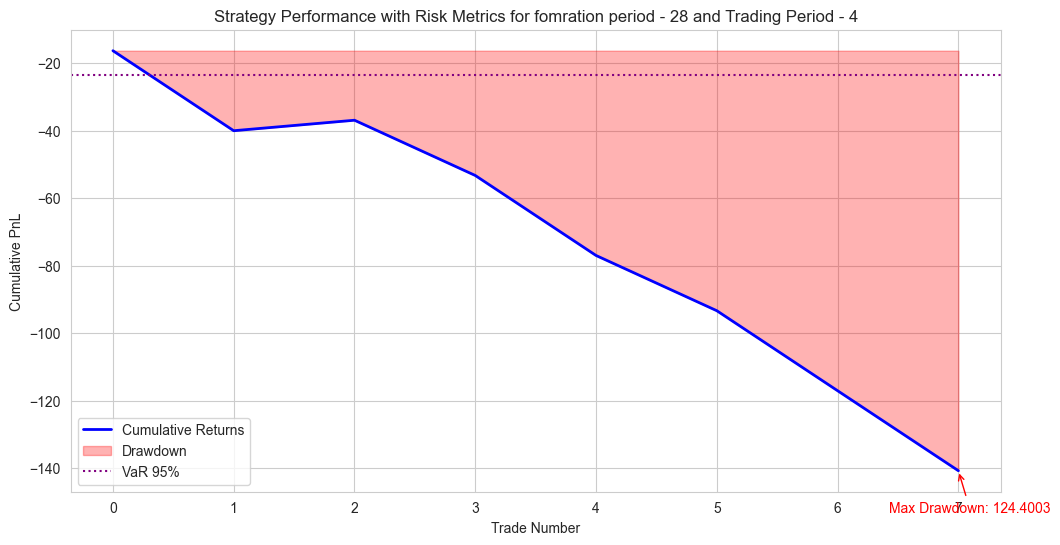

Running for formation - 28 and Trading - 5
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  800
Total Profit/Loss Realized in this Trading Period ==========>  -4.122118272415435
Percentage terms =======>  0.9948473521594807
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  800
Total Profit/Loss Realized in this Trading Period ==========>  -2.228807214760561
Percentage terms =======>  0.9972139909815493
Total Investment in this Trading Period ============>  800
Total Profit/Loss Realized in this Trading Period ==========>  -4.122118272415435
Percentage terms =======>  0.9948473521594807
Total Investment in this Trading Period ============>  200
Total Profit/Loss Realized in this Trading Period ==========>  4.060606745700911
Percentage terms =======>  1.0203030337285046
Total Investment in this Trading 

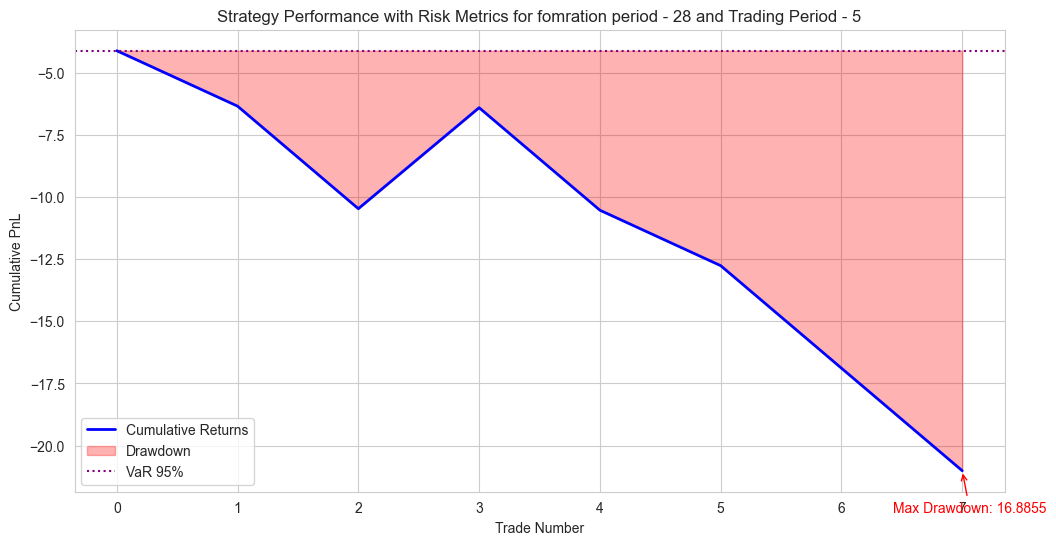

Running for formation - 28 and Trading - 6
price
Total Investment in this Trading Period ============>  800
Total Profit/Loss Realized in this Trading Period ==========>  0.28566231259182473
Percentage terms =======>  1.0003570778907398
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  600
Total Profit/Loss Realized in this Trading Period ==========>  2.0876917905627046
Percentage terms =======>  1.0034794863176044
Total Investment in this Trading Period ============>  1000
Total Profit/Loss Realized in this Trading Period ==========>  -8.507915540565113
Percentage terms =======>  0.9914920844594349
Total Investment in this Trading Period ============>  400
Total Profit/Loss Realized in this Trading Period ==========>  4.060606745700911
Percentage terms =======>  1.0101515168642523
Total Investment in this Trading Period ============>  1200
Total Profit/Loss Realized i

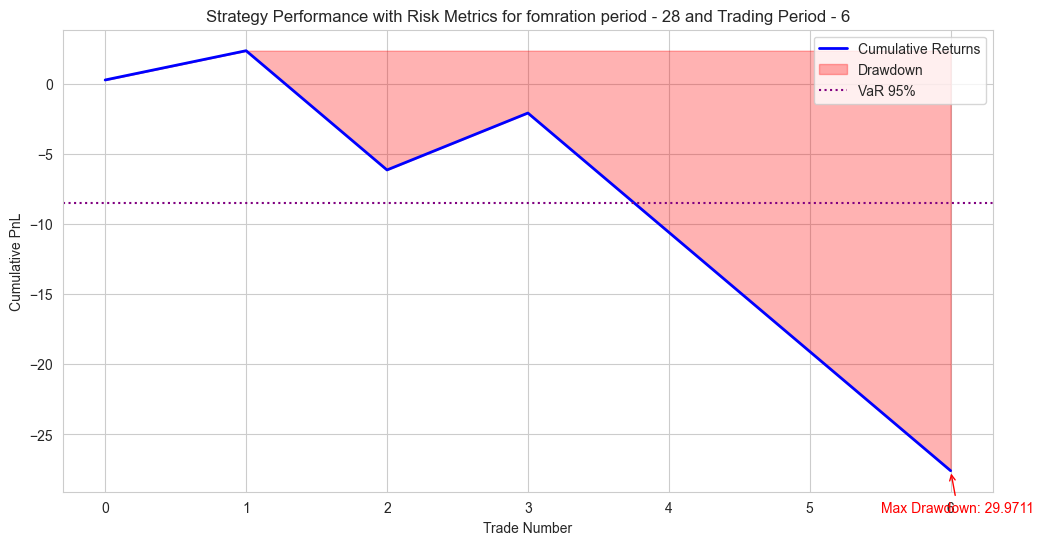

Running for formation - 28 and Trading - 7
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  1200
Total Profit/Loss Realized in this Trading Period ==========>  8.451712535812185
Percentage terms =======>  1.0070430937798436
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  1400
Total Profit/Loss Realized in this Trading Period ==========>  -1.7822276874205016
Percentage terms =======>  0.9987269802232711
Total Investment in this Trading Period ============>  400
Total Profit/Loss Realized in this Trading Period ==========>  4.436582307841299
Percentage terms =======>  1.0110914557696034
Total Investment in this Trading Period ============>  1400
Total Profit/Loss Realized in this Trading Period ==========>  -1.7822276874205016
Percentage terms =======>  0.9987269802232711
Total Investment in this Trading Period ============>  1400
Total Profit/Loss Realized

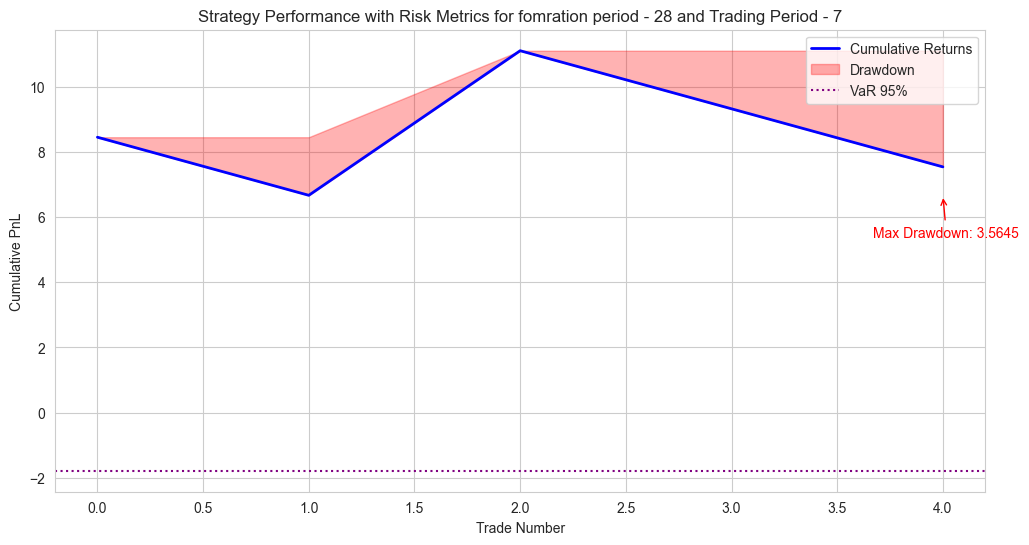

Running for formation - 28 and Trading - 8
price
Total Investment in this Trading Period ============>  1200
Total Profit/Loss Realized in this Trading Period ==========>  13.067278695017265
Percentage terms =======>  1.0108893989125143
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  1200
Total Profit/Loss Realized in this Trading Period ==========>  -7.040618066037631
Percentage terms =======>  0.994132818278302
Total Investment in this Trading Period ============>  1400
Total Profit/Loss Realized in this Trading Period ==========>  9.555073817728093
Percentage terms =======>  1.0068250527269487
Total Investment in this Trading Period ============>  1400
Total Profit/Loss Realized in this Trading Period ==========>  9.555073817728093
Percentage terms =======>  1.0068250527269487
   0
0  3
1  0
2  0
3  6
4  6
5  7
25.13680826443582
Mean Return: 6.2842
Std Dev: 9.0362

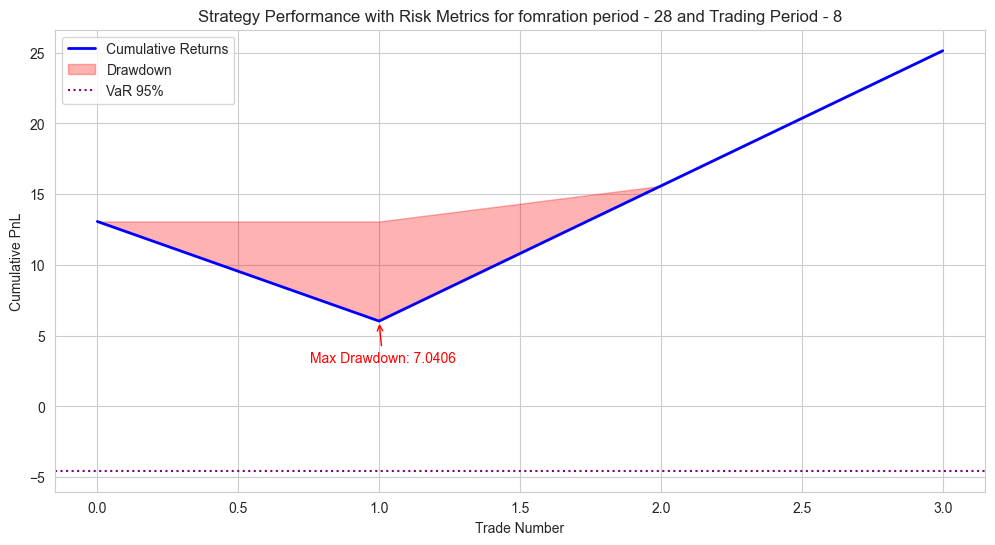

Running for formation - 28 and Trading - 9
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  1200
Total Profit/Loss Realized in this Trading Period ==========>  -4.861944544649077
Percentage terms =======>  0.9959483795461258
Total Investment in this Trading Period ============>  800
Total Profit/Loss Realized in this Trading Period ==========>  -3.4064237281207035
Percentage terms =======>  0.9957419703398491
Total Investment in this Trading Period ============>  1800
Total Profit/Loss Realized in this Trading Period ==========>  -19.551340435069434
Percentage terms =======>  0.9891381442027392
Total Investment in this Trading Period ============>  1800
Total Profit/Loss Realized in this Trading Period ==========>  -19.551340435069434
Percentage terms =======>  0.9891381442027392
   0
0  0
1  0
2  6
3  4
4  9
5  9
-47.371049142908646
Mean Return: -11.8428
Std De

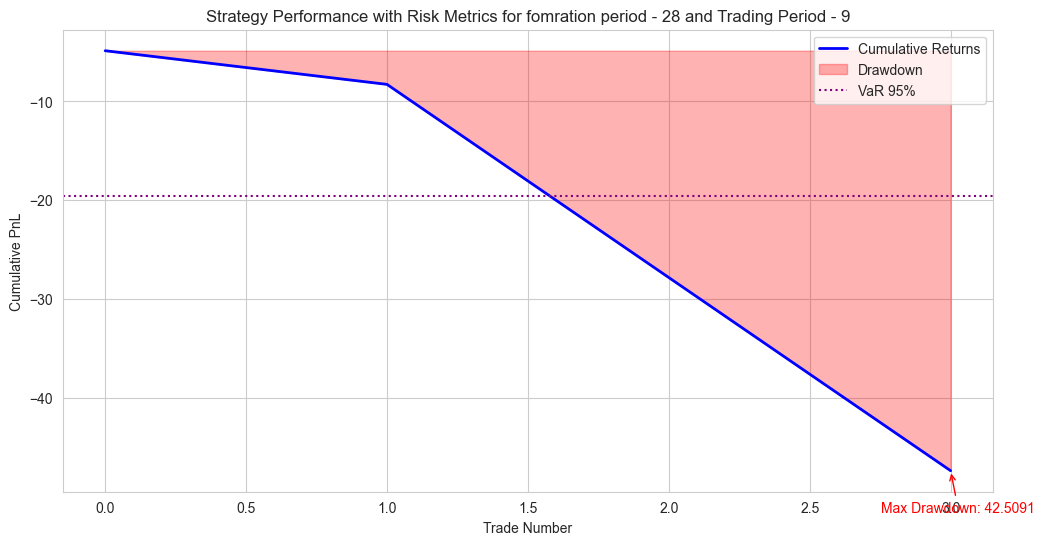

Running for formation - 28 and Trading - 10
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  800
Total Profit/Loss Realized in this Trading Period ==========>  -4.122118272415435
Percentage terms =======>  0.9948473521594807
Total Investment in this Trading Period ============>  1600
Total Profit/Loss Realized in this Trading Period ==========>  -2.6253083419420307
Percentage terms =======>  0.9983591822862863
Total Investment in this Trading Period ============>  1200
Total Profit/Loss Realized in this Trading Period ==========>  4.345429024887533
Percentage terms =======>  1.0036211908540729
Total Investment in this Trading Period ============>  1800
Total Profit/Loss Realized in this Trading Period ==========>  -2.6253083419420307
Percentage terms =======>  0.9985414953655878
   0
0  0
1  1
2  8
3  6
4  9
-5.027305931411963
Mean Return: -1.2568
Std Dev: 3.8009
Sharpe Ratio: -0.3307
Sortino Ratio: -1.4544
Max Drawdo

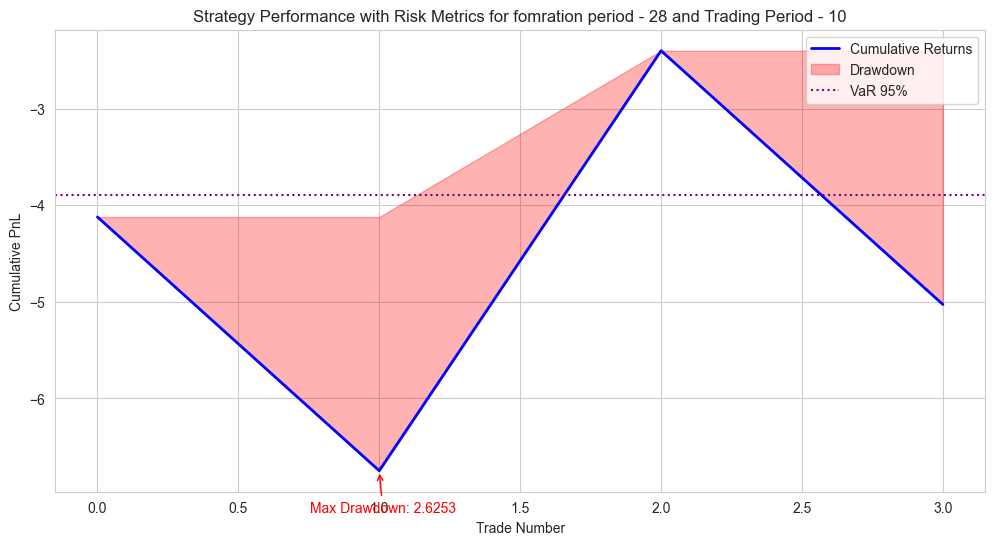

Running for formation - 28 and Trading - 11
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  1200
Total Profit/Loss Realized in this Trading Period ==========>  9.555073817728093
Percentage terms =======>  1.0079625615147734
Total Investment in this Trading Period ============>  2000
Total Profit/Loss Realized in this Trading Period ==========>  39.296454927978566
Percentage terms =======>  1.0196482274639893
Total Investment in this Trading Period ============>  2200
Total Profit/Loss Realized in this Trading Period ==========>  39.296454927978566
Percentage terms =======>  1.017862024967263
    0
0   0
1   0
2   6
3   8
4  11
88.14798367368522
Mean Return: 29.3827
Std Dev: 17.1712
Sharpe Ratio: 1.7112
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: 12.5292
CVaR 95%: 9.5551
Skewness: -0.7071
Kurtosis: -1.5000


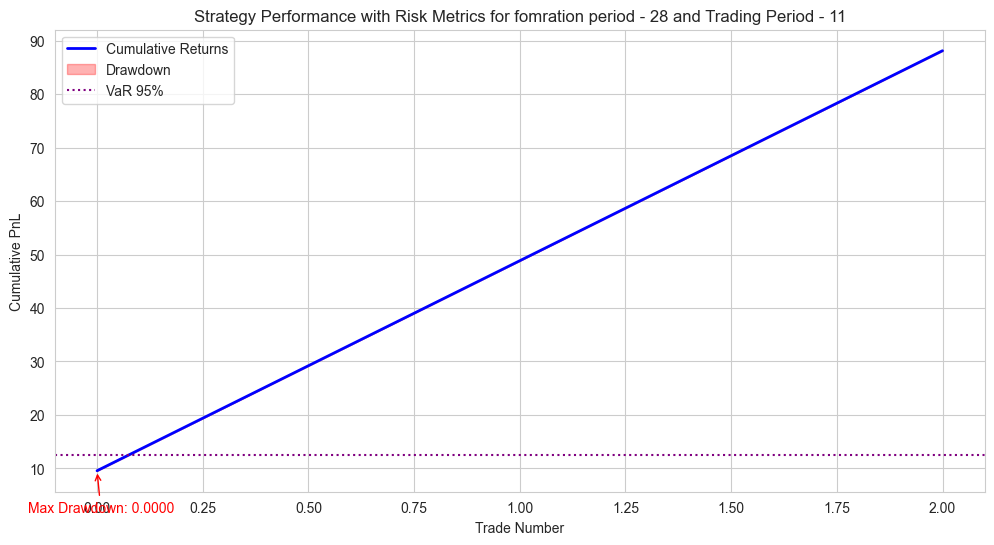

Running for formation - 28 and Trading - 12
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  1200
Total Profit/Loss Realized in this Trading Period ==========>  -8.507915540565113
Percentage terms =======>  0.9929100703828624
Total Investment in this Trading Period ============>  2400
Total Profit/Loss Realized in this Trading Period ==========>  47.33303270286294
Percentage terms =======>  1.0197220969595262
    0
0   0
1   0
2   6
3  12
38.82511716229782
Mean Return: 19.4126
Std Dev: 39.4855
Sharpe Ratio: 0.4916
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: -5.7159
CVaR 95%: -8.5079
Skewness: 0.0000
Kurtosis: -2.0000


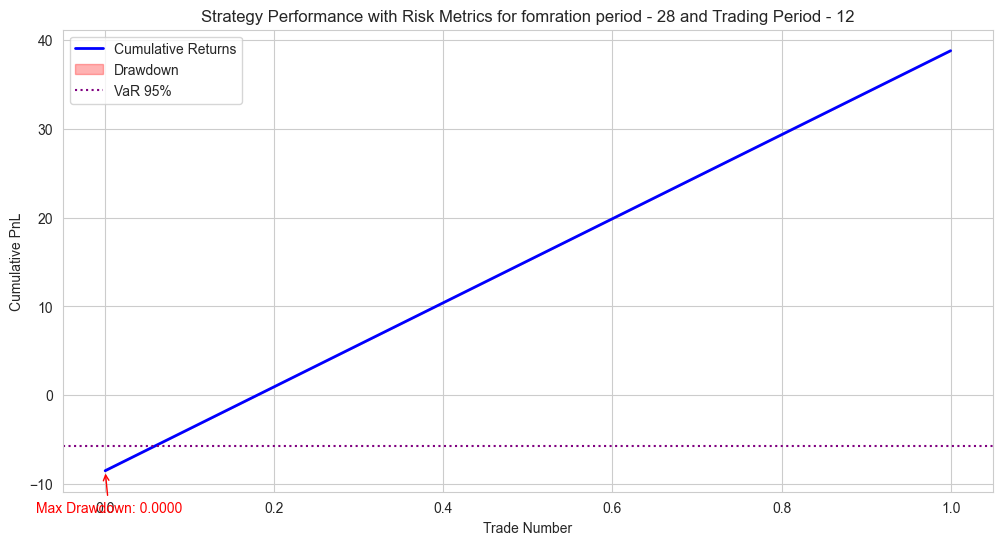

Running for formation - 28 and Trading - 13
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  1800
Total Profit/Loss Realized in this Trading Period ==========>  -10.75518929899593
Percentage terms =======>  0.9940248948338911
Total Investment in this Trading Period ============>  2600
Total Profit/Loss Realized in this Trading Period ==========>  101.92472747475307
Percentage terms =======>  1.0392018182595204
    0
0   0
1   0
2   9
3  13
91.16953817575714
Mean Return: 45.5848
Std Dev: 79.6767
Sharpe Ratio: 0.5721
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: -5.1212
CVaR 95%: -10.7552
Skewness: 0.0000
Kurtosis: -2.0000


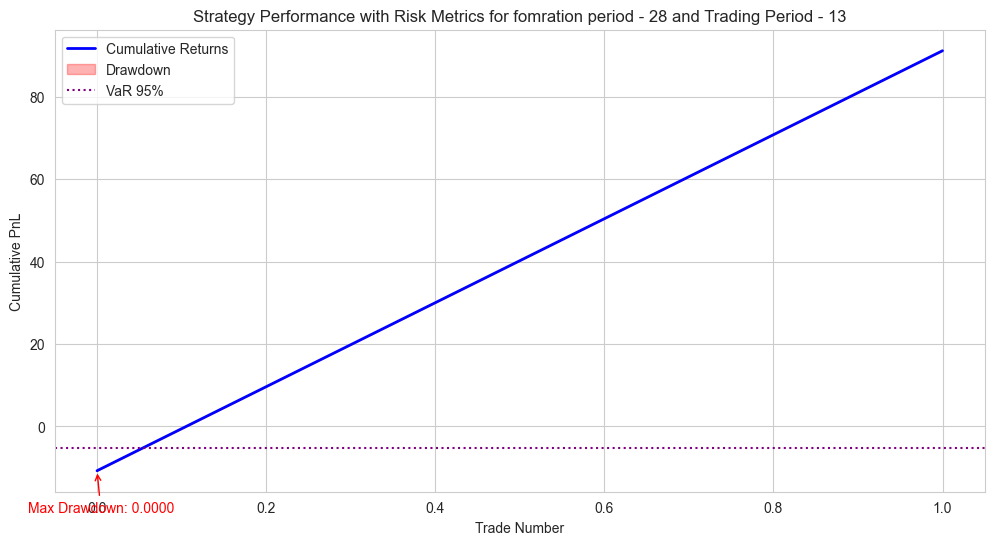

Running for formation - 28 and Trading - 14
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  1800
Total Profit/Loss Realized in this Trading Period ==========>  13.067989991696791
Percentage terms =======>  1.0072599944398315
   0
0  0
1  0
2  8
13.067989991696791
Mean Return: 13.0680
Std Dev: nan
Sharpe Ratio: nan
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: 13.0680
CVaR 95%: 13.0680
Skewness: nan
Kurtosis: nan


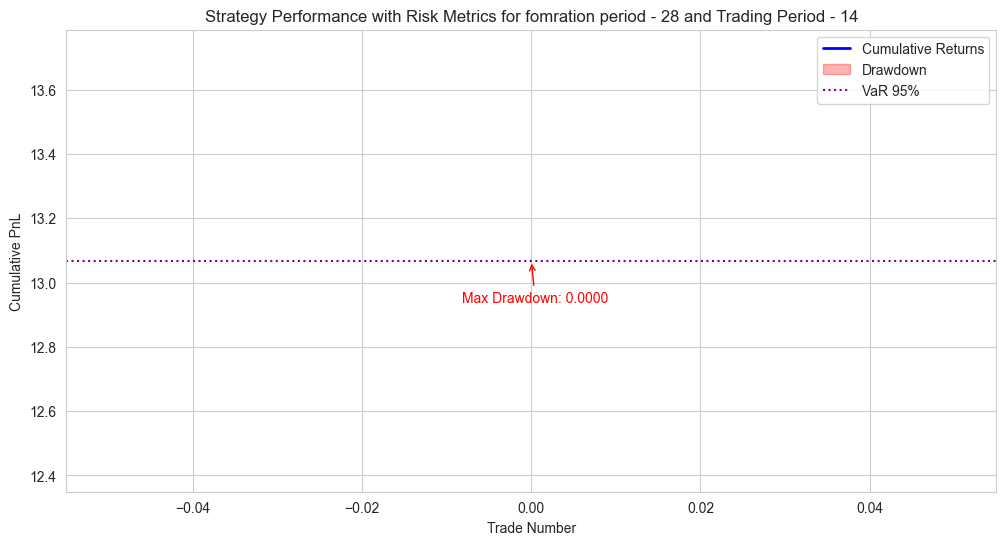

Running for formation - 28 and Trading - 15
price
Total Investment in this Trading Period ============>  2200
Total Profit/Loss Realized in this Trading Period ==========>  19.651965904755677
Percentage terms =======>  1.008932711774889
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  2200
Total Profit/Loss Realized in this Trading Period ==========>  74.88694545381526
Percentage terms =======>  1.034039520660825
   0
0  6
1  0
2  9
94.53891135857094
Mean Return: 47.2695
Std Dev: 39.0570
Sharpe Ratio: 1.2103
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: 22.4137
CVaR 95%: 19.6520
Skewness: -0.0000
Kurtosis: -2.0000


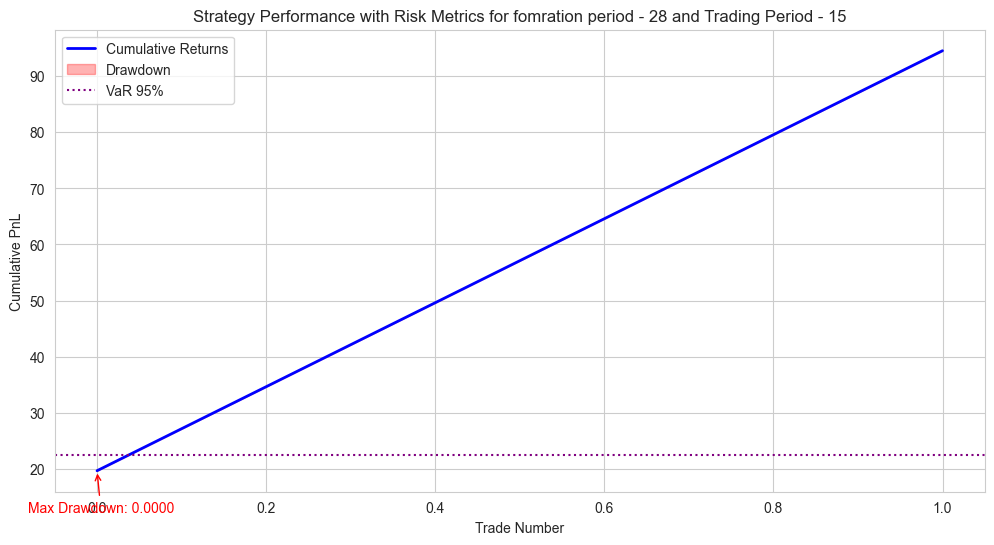

Running for formation - 28 and Trading - 16
price
Total Investment in this Trading Period ============>  2200
Total Profit/Loss Realized in this Trading Period ==========>  19.651965904755677
Percentage terms =======>  1.008932711774889
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  3000
Total Profit/Loss Realized in this Trading Period ==========>  121.1405843474895
Percentage terms =======>  1.0403801947824964
    0
0   6
1   0
2  12
140.79255025224518
Mean Return: 70.3963
Std Dev: 71.7633
Sharpe Ratio: 0.9810
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: 24.7264
CVaR 95%: 19.6520
Skewness: -0.0000
Kurtosis: -2.0000


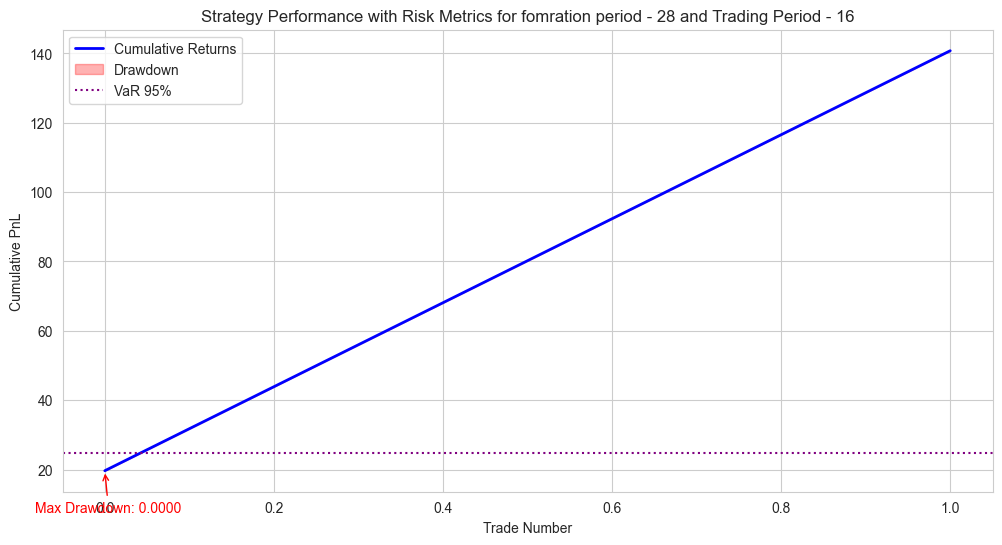

Running for formation - 28 and Trading - 17
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  3200
Total Profit/Loss Realized in this Trading Period ==========>  159.0498337781995
Percentage terms =======>  1.0497030730556873
    0
0   0
1   0
2  16
159.0498337781995
Mean Return: 159.0498
Std Dev: nan
Sharpe Ratio: nan
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: 159.0498
CVaR 95%: 159.0498
Skewness: nan
Kurtosis: nan


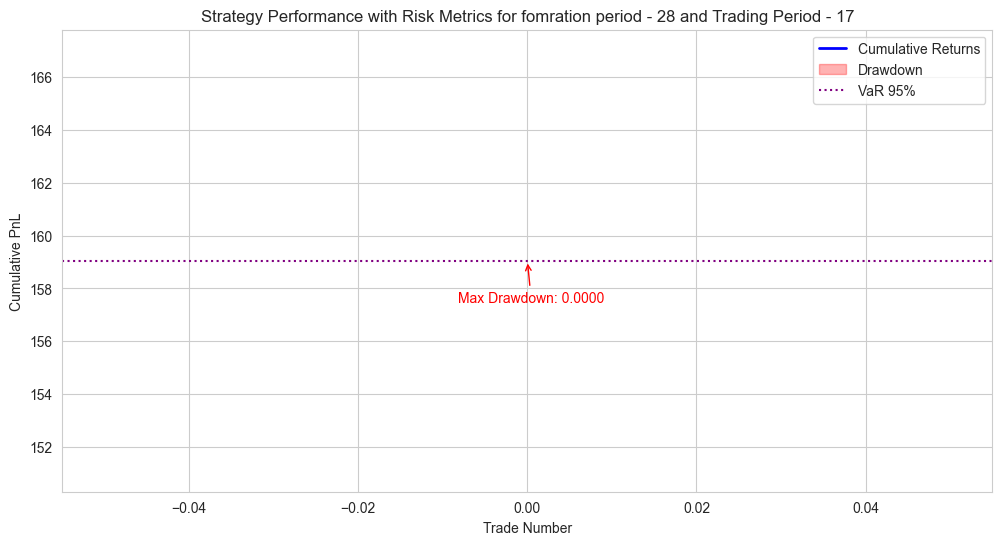

Running for formation - 28 and Trading - 18
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  2800
Total Profit/Loss Realized in this Trading Period ==========>  105.64718599407192
Percentage terms =======>  1.0377311378550256
Total Investment in this Trading Period ============>  3600
Total Profit/Loss Realized in this Trading Period ==========>  237.34539727091604
Percentage terms =======>  1.0659292770196989
    0
0   0
1  12
2  18
342.99258326498796
Mean Return: 171.4963
Std Dev: 93.1247
Sharpe Ratio: 1.8416
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: 112.2321
CVaR 95%: 105.6472
Skewness: 0.0000
Kurtosis: -2.0000


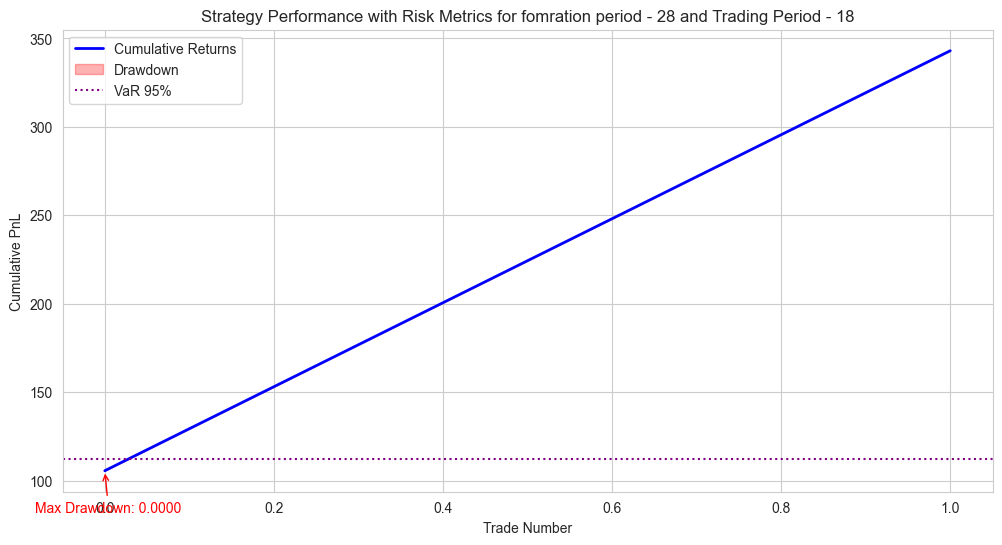

Running for formation - 28 and Trading - 19
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  3200
Total Profit/Loss Realized in this Trading Period ==========>  54.96104141689179
Percentage terms =======>  1.0171753254427787
    0
0   0
1  14
54.96104141689179
Mean Return: 54.9610
Std Dev: nan
Sharpe Ratio: nan
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: 54.9610
CVaR 95%: 54.9610
Skewness: nan
Kurtosis: nan


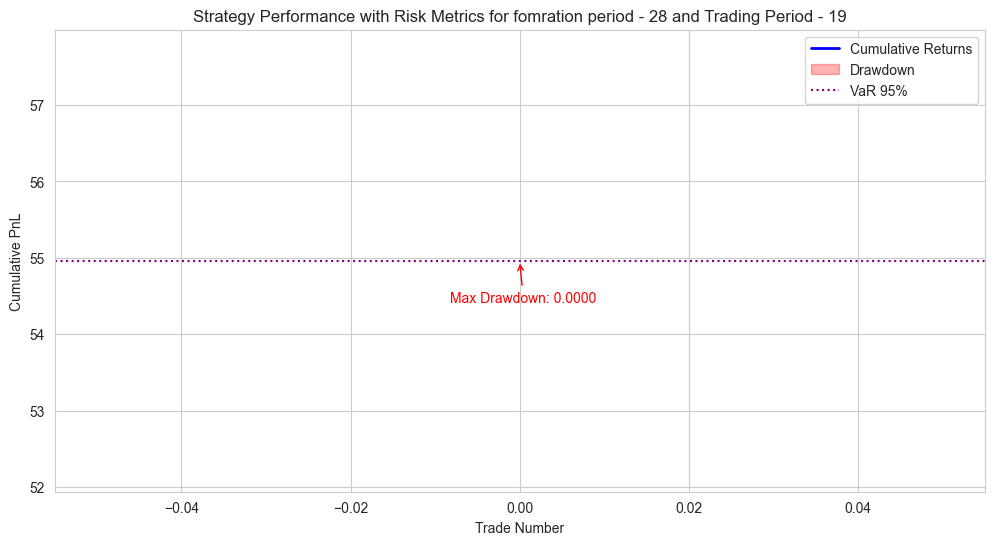

Running for formation - 28 and Trading - 20
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  3600
Total Profit/Loss Realized in this Trading Period ==========>  152.27501477874108
Percentage terms =======>  1.042298615216317
    0
0   0
1  15
152.27501477874108
Mean Return: 152.2750
Std Dev: nan
Sharpe Ratio: nan
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: 152.2750
CVaR 95%: 152.2750
Skewness: nan
Kurtosis: nan


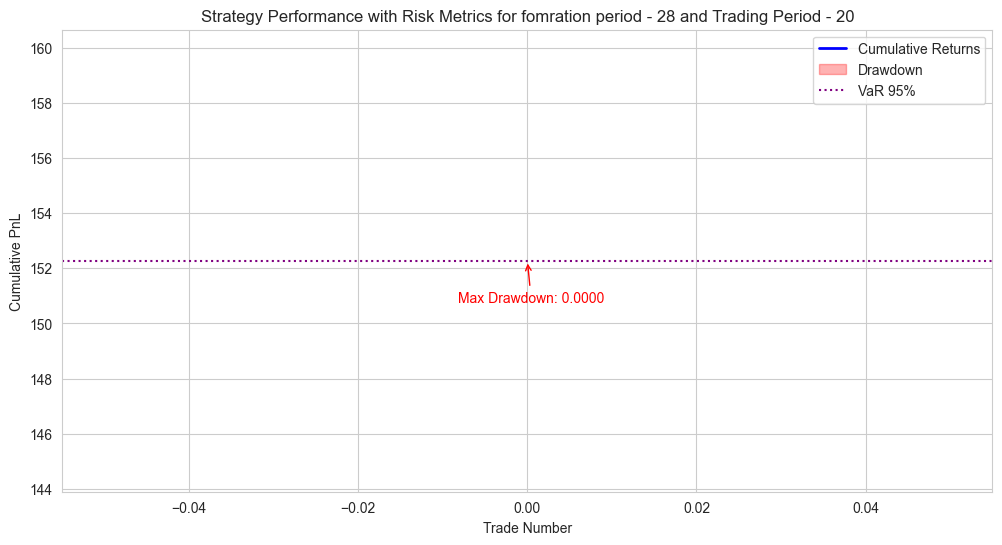

Running for formation - 28 and Trading - 21
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  3400
Total Profit/Loss Realized in this Trading Period ==========>  31.843065780833758
Percentage terms =======>  1.009365607582598
    0
0   0
1  16
31.843065780833758
Mean Return: 31.8431
Std Dev: nan
Sharpe Ratio: nan
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: 31.8431
CVaR 95%: 31.8431
Skewness: nan
Kurtosis: nan


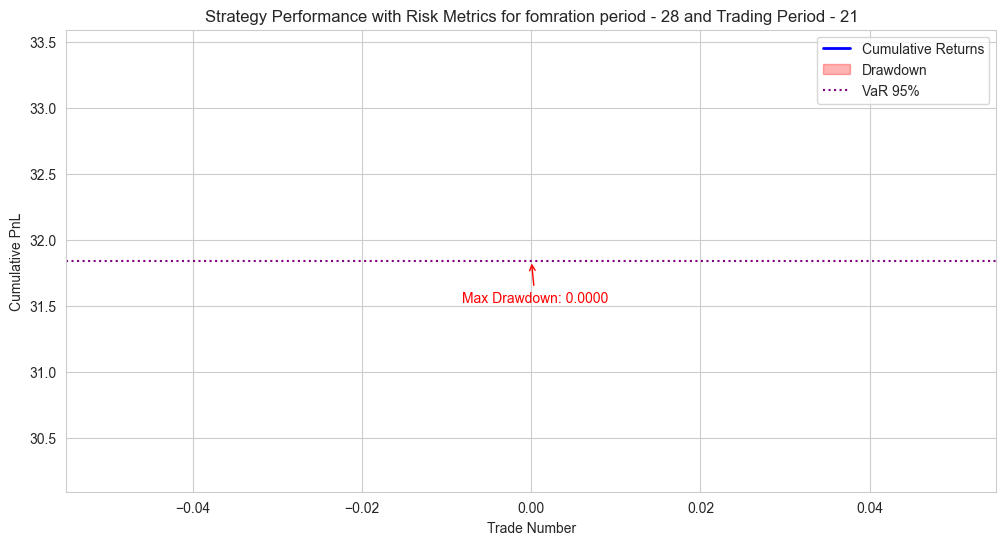

Running for formation - 28 and Trading - 22
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  3400
Total Profit/Loss Realized in this Trading Period ==========>  83.1809307117552
Percentage terms =======>  1.0244649796211045
    0
0   0
1  16
83.1809307117552
Mean Return: 83.1809
Std Dev: nan
Sharpe Ratio: nan
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: 83.1809
CVaR 95%: 83.1809
Skewness: nan
Kurtosis: nan


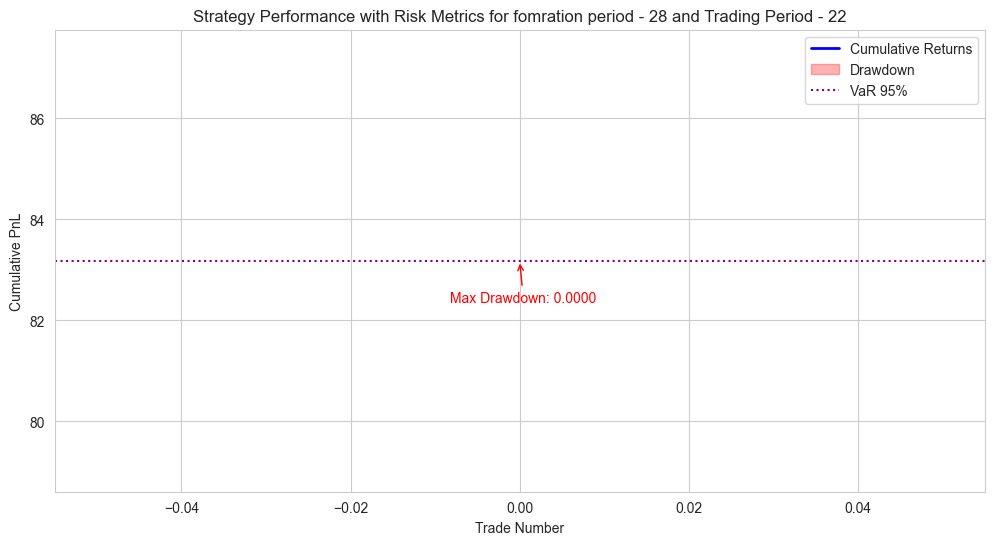

Running for formation - 28 and Trading - 23
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  2800
Total Profit/Loss Realized in this Trading Period ==========>  34.67094901065538
Percentage terms =======>  1.0123824817895197
    0
0   0
1  13
34.67094901065538
Mean Return: 34.6709
Std Dev: nan
Sharpe Ratio: nan
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: 34.6709
CVaR 95%: 34.6709
Skewness: nan
Kurtosis: nan


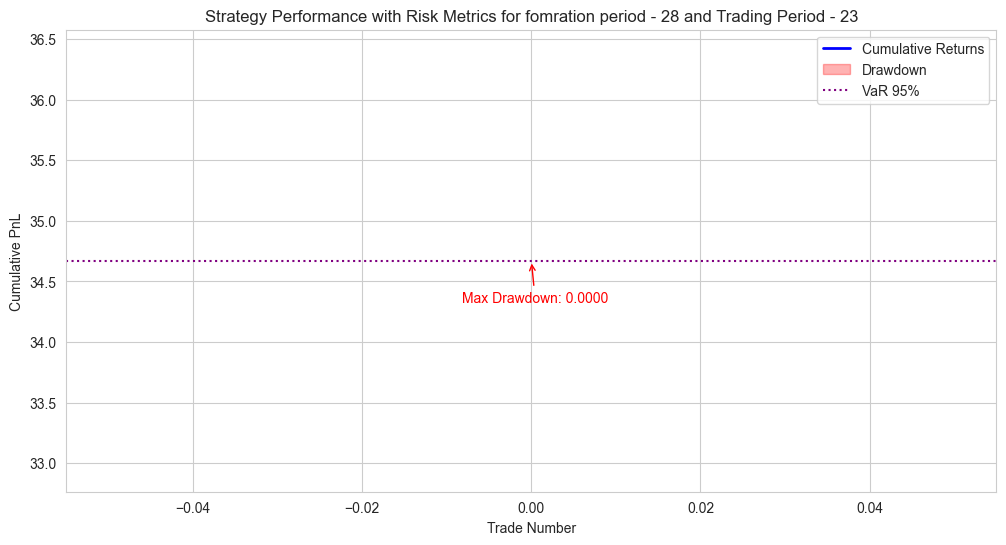

Running for formation - 28 and Trading - 24
price
Total Investment in this Trading Period ============>  2400
Total Profit/Loss Realized in this Trading Period ==========>  19.651965904755677
Percentage terms =======>  1.0081883191269816
Total Investment in this Trading Period ============>  3200
Total Profit/Loss Realized in this Trading Period ==========>  42.76794643651157
Percentage terms =======>  1.0133649832614098
    0
0   7
1  16
62.41991234126725
Mean Return: 31.2100
Std Dev: 16.3455
Sharpe Ratio: 1.9094
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: 20.8078
CVaR 95%: 19.6520
Skewness: 0.0000
Kurtosis: -2.0000


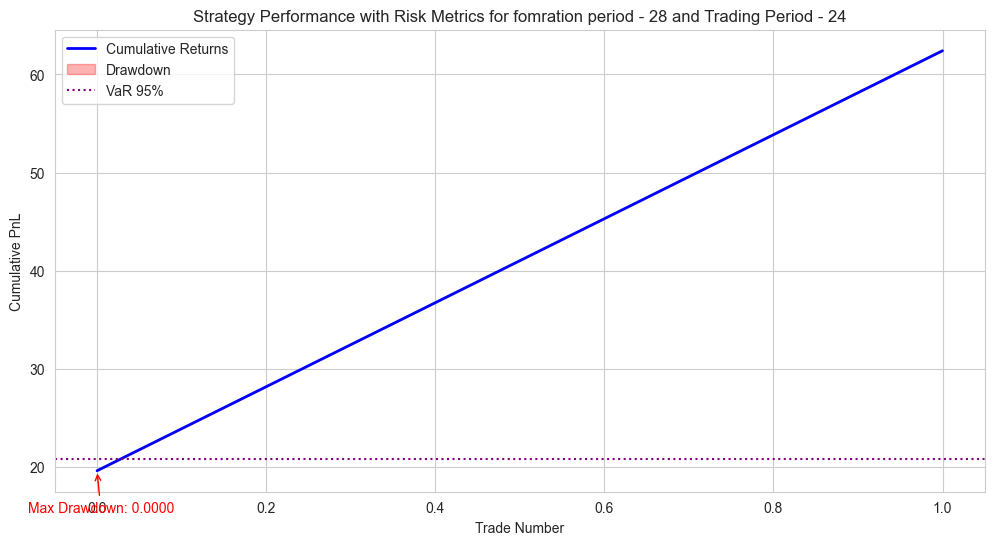

Running for formation - 28 and Trading - 25
price
Total Investment in this Trading Period ============>  2800
Total Profit/Loss Realized in this Trading Period ==========>  26.785119883167752
Percentage terms =======>  1.0095661142439885
Total Investment in this Trading Period ============>  3800
Total Profit/Loss Realized in this Trading Period ==========>  71.76557559421276
Percentage terms =======>  1.0188856777879507
    0
0   8
1  18
98.55069547738051
Mean Return: 49.2753
Std Dev: 31.8060
Sharpe Ratio: 1.5492
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: 29.0341
CVaR 95%: 26.7851
Skewness: 0.0000
Kurtosis: -2.0000


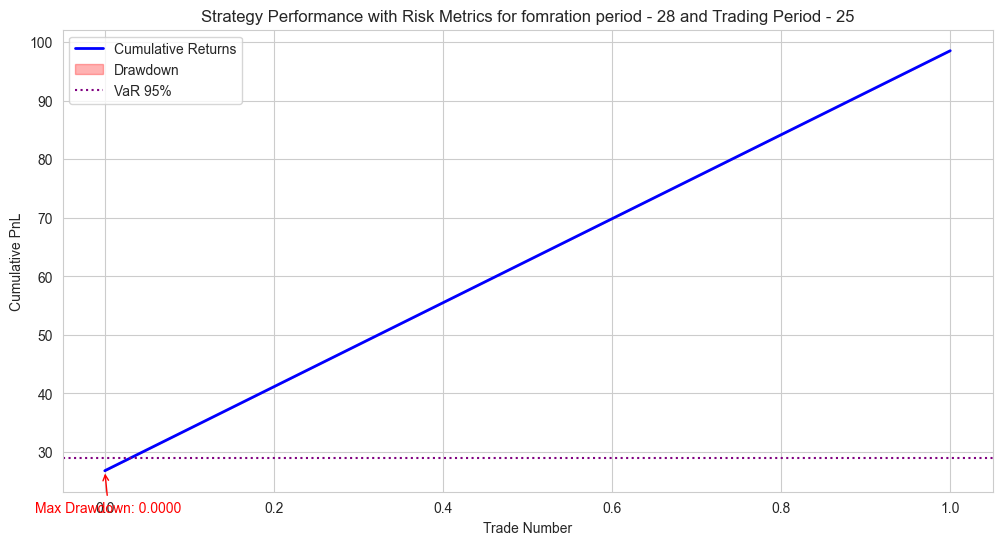

Running for formation - 28 and Trading - 26
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  4000
Total Profit/Loss Realized in this Trading Period ==========>  38.08420700536013
Percentage terms =======>  1.00952105175134
    0
0   0
1  19
38.08420700536013
Mean Return: 38.0842
Std Dev: nan
Sharpe Ratio: nan
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: 38.0842
CVaR 95%: 38.0842
Skewness: nan
Kurtosis: nan


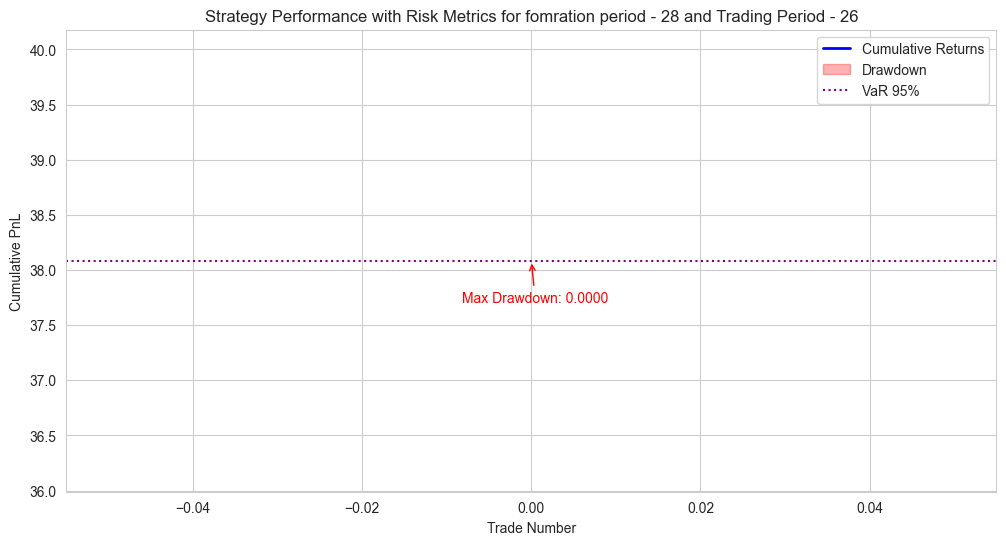

Running for formation - 28 and Trading - 27
price
Total Investment in this Trading Period ============>  0
Total Investment in this Trading Period ============>  4400
Total Profit/Loss Realized in this Trading Period ==========>  185.29110148358495
Percentage terms =======>  1.042111613973542
    0
0   0
1  20
185.29110148358495
Mean Return: 185.2911
Std Dev: nan
Sharpe Ratio: nan
Sortino Ratio: nan
Max Drawdown: 0.0000
VaR 95%: 185.2911
CVaR 95%: 185.2911
Skewness: nan
Kurtosis: nan


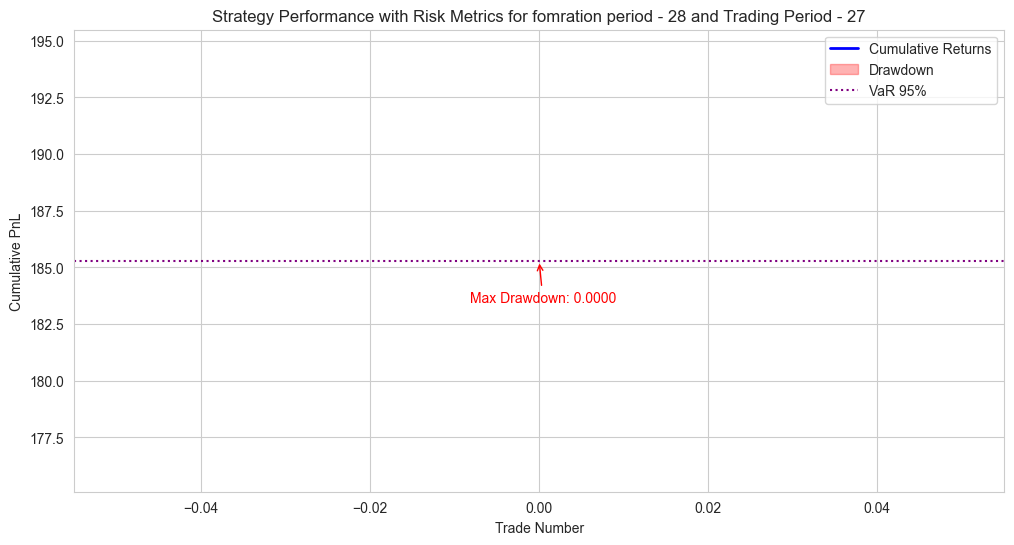

Running for formation - 28 and Trading - 28
price
Total Investment in this Trading Period ============>  0
   0
0  0
0
Mean Return: nan
Std Dev: nan
Sharpe Ratio: nan
Sortino Ratio: nan
Max Drawdown: nan
VaR 95%: nan
CVaR 95%: nan
Skewness: nan
Kurtosis: nan


ValueError: zero-size array to reduction operation maximum which has no identity

In [14]:
for F in range(27,40):
    for T in range(4,F+1):
        formation_period = F
        trading_period = T
        print(f"Running for formation - {F} and Trading - {T}")
        res = []
        prev_sum = 0
        for feature in feature_list[-1:]:
            try:
                df = dfx.pivot(index="DATE", columns="permno", values=feature)
                df = np.log(df[:]/df[:].shift(1))
                train_df = df.loc[1:int(len(df) * 2 / 3), :]
                test_df = df.loc[int(len(df) * 2 / 3) + 1:, :]
                trading_date_num = len(test_df)
                df1 = train_df.loc[:, [28388 , 85058]]
                df2 = test_df.loc[:, [28388 , 85058]]
                stock_1 = (dfx_s1)
                stock_2 = (dfx_s2)
                stocks_3D = np.stack((stock_1, stock_2), axis=2)
                stocks_3D = (stocks_3D - stocks_3D.mean(axis=0)) / stocks_3D.std(axis=0)
                print(feature)
                Rolling_Window(stocks_3D)
                print(sum(res) - prev_sum)
                prev_sum = sum(res)
            except Exception as e:
                print(e)
                print(f'Cannot Use Feature {feature}')
                continue
        metrics = evaluate_result(res,F,T)
        net_results[(F,T)] = metrics

In [15]:
net_results

{(6, 4): {'Mean Return': -16.868128065270028,
  'Std Dev': 9.543042149032368,
  'Sharpe Ratio': -1.7675839425041624,
  'Sortino Ratio': -1.7675839425041624,
  'Max Drawdown': 263.0632986788512,
  'VaR 95%': -23.694878430739244,
  'CVaR 95%': -23.694878430739244,
  'Skewness': 0.6258014236451038,
  'Kurtosis': -1.5927809499696646},
 (6, 5): {'Mean Return': -2.93058190124713,
  'Std Dev': 2.3182384320900886,
  'Sharpe Ratio': -1.2641417123798442,
  'Sortino Ratio': -2.0937562613483722,
  'Max Drawdown': 31.044864542550123,
  'VaR 95%': -4.460339591020172,
  'CVaR 95%': -4.873721202648184,
  'Skewness': 1.6997070208957166,
  'Kurtosis': 1.836717155181102},
 (6, 6): {'Mean Return': -7.027996573355946,
  'Std Dev': 2.62954016016018,
  'Sharpe Ratio': -2.67270935041655,
  'Sortino Ratio': -2.67270935041655,
  'Max Drawdown': 54.74405361963839,
  'VaR 95%': -8.507915540565113,
  'CVaR 95%': -8.507915540565113,
  'Skewness': 1.6431119427038319,
  'Kurtosis': 1.4912726906686986},
 (7, 4): {'Mea

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

data = []
for (F, T), metrics in net_results.items():
    metrics["formation_period"] = F
    metrics["trading_period"] = T
    data.append(metrics)

df = pd.DataFrame(data)
df = df.dropna()

grouped = df.groupby("trading_period").agg(
    avg_sharpe=("Sharpe Ratio", "mean"),
    med_sharpe=("Sharpe Ratio", "median"),
    std_sharpe=("Sharpe Ratio", "std"),
    avg_sortino=("Sortino Ratio", "mean"),
    med_sortino=("Sortino Ratio", "median"),
    std_sortino=("Sortino Ratio", "std"),
    avg_VaR=("VaR 95%", "mean"),
    med_VaR=("VaR 95%", "median"),
    avg_CVaR=("CVaR 95%", "mean"),
    med_CVaR=("CVaR 95%", "median"),
    count=("Sharpe Ratio", "count"),
    IQR_sharpe=("Sharpe Ratio", lambda x: np.percentile(x.dropna(), 75) - np.percentile(x.dropna(), 25))
)
grouped["weighted_avg_sharpe"] = (df["Sharpe Ratio"] * df["trading_period"]).sum() / df["trading_period"].sum()

grouped = grouped.sort_index()
print(grouped)


                avg_sharpe  med_sharpe  std_sharpe   avg_sortino  med_sortino   
trading_period                                                                  
4                -1.871053   -1.849953    0.390699 -1.898512e+14    -2.244125  \
5                -1.013926   -0.772057    0.990825           NaN    -1.556623   
6                -1.459162   -1.363007    0.871606          -inf    -1.921375   
7                -0.385888   -0.512762    0.483016           NaN    -0.588258   
8                 0.422529    0.416671    0.355872           NaN     3.160640   
9                -1.316743   -1.346325    0.545961 -1.461941e+00    -1.390370   
10               -0.844967   -0.758413    0.830129 -1.020132e+00    -0.877582   
11                0.584525    0.558763    0.172010  9.365378e+00     3.063438   
12                0.519595    0.504248    0.204919  3.892183e+00     2.991803   
13                0.440712    0.445771    0.065442  2.597943e+00     2.449252   
14                0.355471  

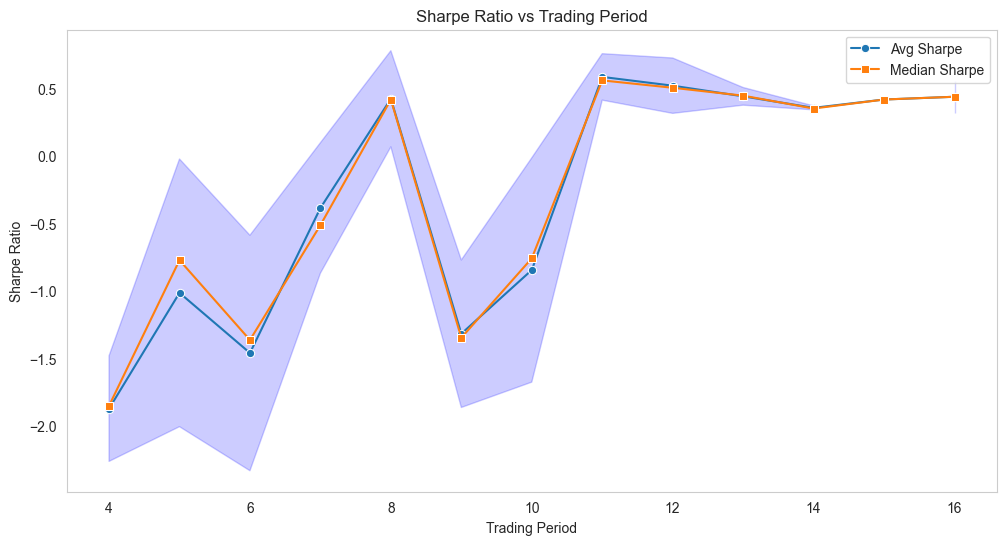

In [19]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=grouped.index, y=grouped["avg_sharpe"], marker="o", label="Avg Sharpe")
sns.lineplot(x=grouped.index, y=grouped["med_sharpe"], marker="s", label="Median Sharpe")
plt.fill_between(grouped.index, grouped["avg_sharpe"] - grouped["std_sharpe"], 
                 grouped["avg_sharpe"] + grouped["std_sharpe"], alpha=0.2, color="blue")
plt.xlabel("Trading Period")
plt.ylabel("Sharpe Ratio")
plt.title("Sharpe Ratio vs Trading Period")
plt.legend()
plt.grid()
plt.show()


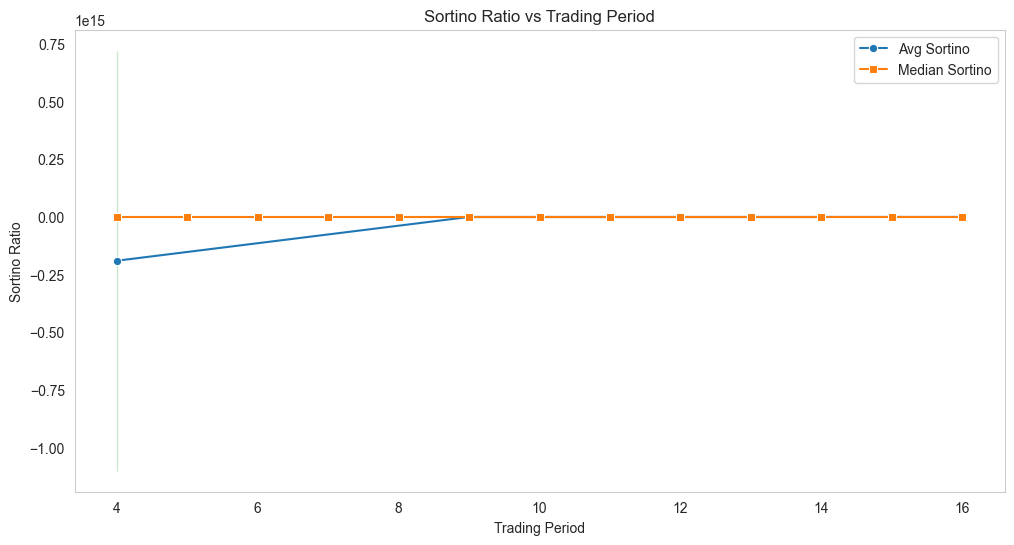

In [20]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=grouped.index, y=grouped["avg_sortino"], marker="o", label="Avg Sortino")
sns.lineplot(x=grouped.index, y=grouped["med_sortino"], marker="s", label="Median Sortino")
plt.fill_between(grouped.index, grouped["avg_sortino"] - grouped["std_sortino"], 
                 grouped["avg_sortino"] + grouped["std_sortino"], alpha=0.2, color="green")
plt.xlabel("Trading Period")
plt.ylabel("Sortino Ratio")
plt.title("Sortino Ratio vs Trading Period")
plt.legend()
plt.grid()
plt.show()


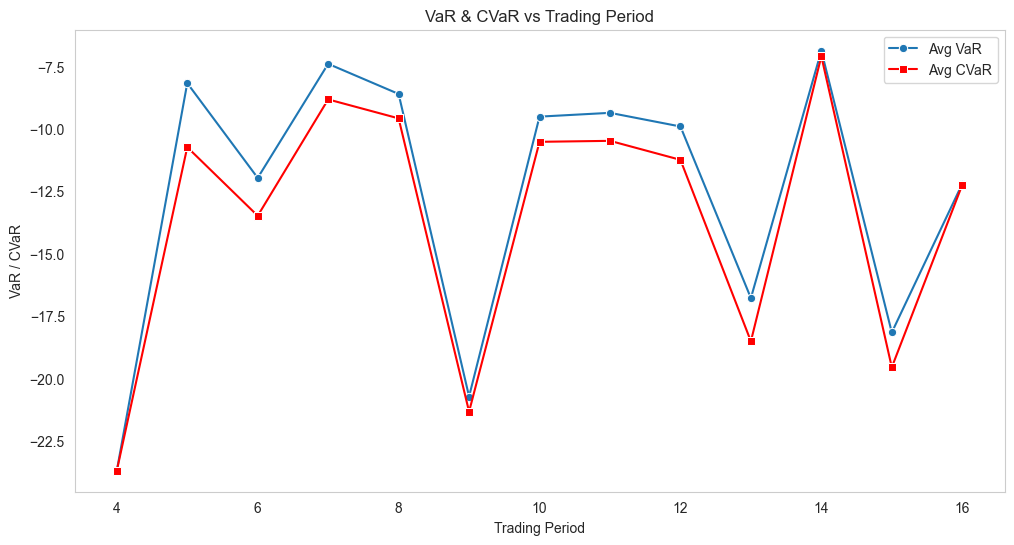

In [21]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=grouped.index, y=grouped["avg_VaR"], marker="o", label="Avg VaR")
sns.lineplot(x=grouped.index, y=grouped["avg_CVaR"], marker="s", label="Avg CVaR", color="red")
plt.xlabel("Trading Period")
plt.ylabel("VaR / CVaR")
plt.title("VaR & CVaR vs Trading Period")
plt.legend()
plt.grid()
plt.show()


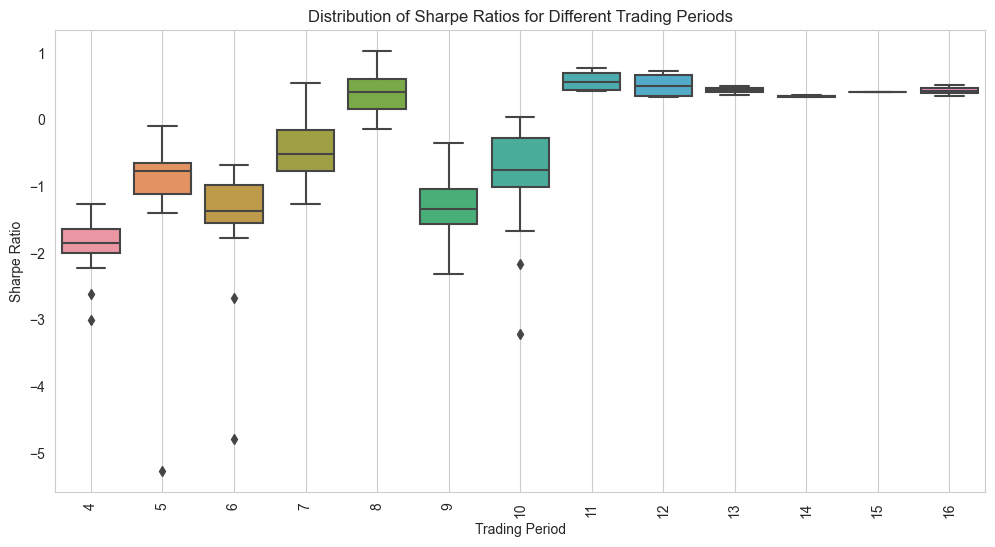

In [23]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=df["trading_period"], y=df["Sharpe Ratio"])
plt.xlabel("Trading Period")
plt.ylabel("Sharpe Ratio")
plt.title("Distribution of Sharpe Ratios for Different Trading Periods")
plt.xticks(rotation=90)
plt.grid()
plt.show()


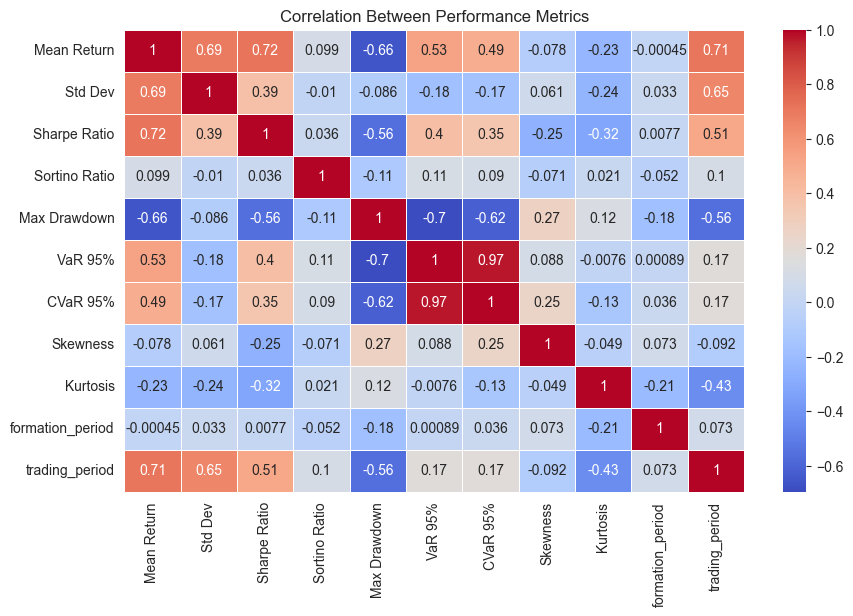

In [24]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Between Performance Metrics")
plt.show()


In [27]:
fig = go.Figure()

fig.add_trace(go.Scatter3d(
    x=df["trading_period"],
    y=df["formation_period"],
    z=df["Sharpe Ratio"],
    mode='markers',
    marker=dict(
        size=5,
        color=df["Sharpe Ratio"],
        colorscale='Viridis',
        opacity=0.8
    )
))

fig.update_layout(
    title="Sharpe Ratio Across Trading & Formation Periods",
    scene=dict(
        xaxis_title="Trading Period",
        yaxis_title="Formation Period",
        zaxis_title="Sharpe Ratio"
    )
)

fig.show()
fig.write_html("strategy_net_performance.html")



In [31]:
sharpe_threshold = 0.2 
positive_ratio_threshold = 0.55
var_threshold = -0.01  
cvar_threshold = -0.02

trading_groups = df.groupby("trading_period")
positive_sharpe_periods = []
ideal_sharpe_periods = []
ideal_risk_periods = []

for period, group in trading_groups:
    sharpe_values = group["Sharpe Ratio"].dropna()
    var_values = group["VaR 95%"].dropna()
    cvar_values = group["CVaR 95%"].dropna()

    if (sharpe_values > 0).mean() >= positive_ratio_threshold:
        positive_sharpe_periods.append(period)

    if sharpe_values.mean() > sharpe_threshold:
        ideal_sharpe_periods.append(period)

    if var_values.mean() < var_threshold and cvar_values.mean() < cvar_threshold:
        ideal_risk_periods.append(period)

print("Trading Periods with Mostly Positive Sharpe:", positive_sharpe_periods)
print("Trading Periods with Ideal Sharpe Ratio:", ideal_sharpe_periods)
print("Trading Periods with Ideal VaR & CVaR:", ideal_risk_periods)


Trading Periods with Mostly Positive Sharpe: [8, 11, 12, 13, 14, 15, 16]
Trading Periods with Ideal Sharpe Ratio: [8, 11, 12, 13, 14, 15, 16]
Trading Periods with Ideal VaR & CVaR: [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]


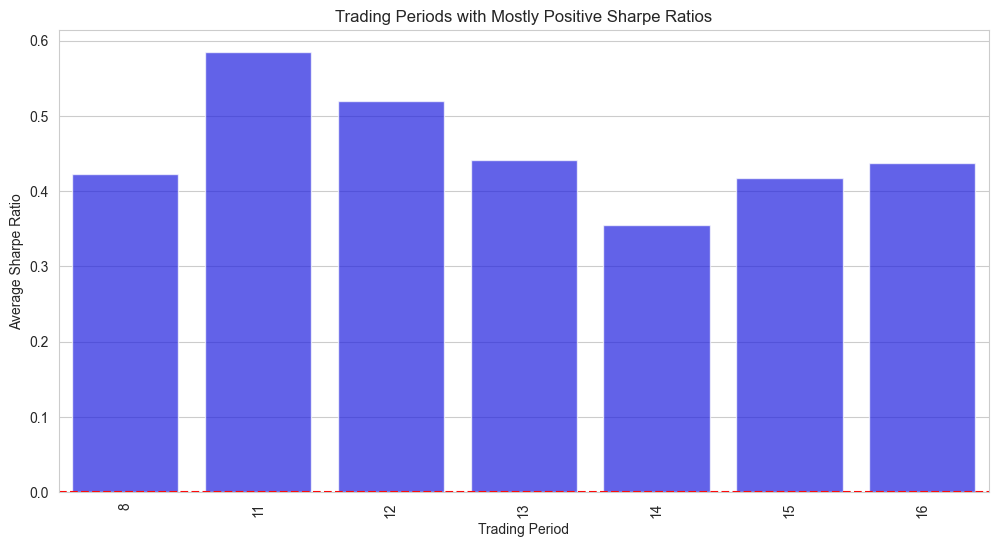

In [32]:
plt.figure(figsize=(12, 6))
sns.barplot(x=grouped.loc[positive_sharpe_periods].index, 
            y=grouped.loc[positive_sharpe_periods, "avg_sharpe"], 
            color="blue", alpha=0.7)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Trading Period")
plt.ylabel("Average Sharpe Ratio")
plt.title("Trading Periods with Mostly Positive Sharpe Ratios")
plt.xticks(rotation=90)
plt.show()


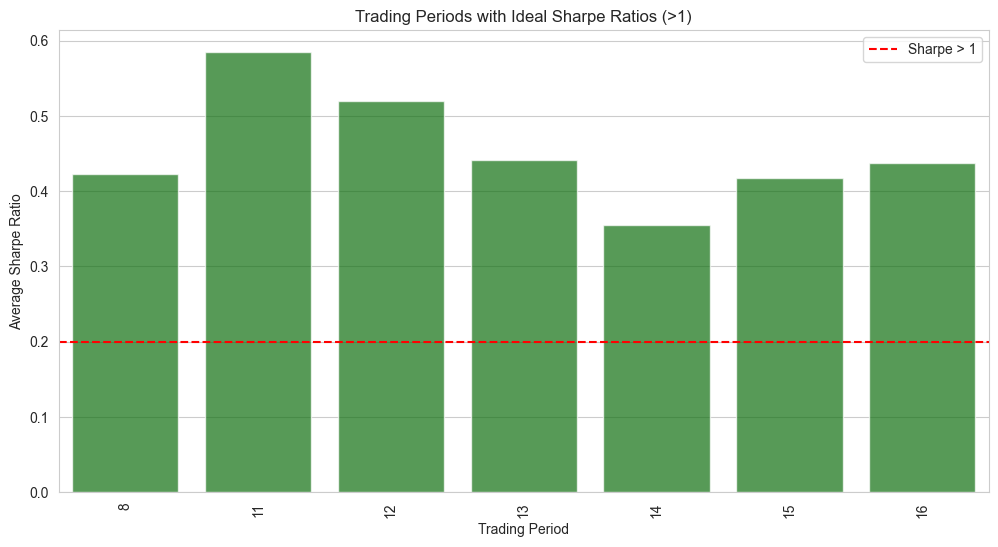

In [33]:
plt.figure(figsize=(12, 6))
sns.barplot(x=grouped.loc[ideal_sharpe_periods].index, 
            y=grouped.loc[ideal_sharpe_periods, "avg_sharpe"], 
            color="green", alpha=0.7)
plt.axhline(sharpe_threshold, color='red', linestyle='--', label="Sharpe > 1")
plt.xlabel("Trading Period")
plt.ylabel("Average Sharpe Ratio")
plt.title("Trading Periods with Ideal Sharpe Ratios (>1)")
plt.legend()
plt.xticks(rotation=90)
plt.show()


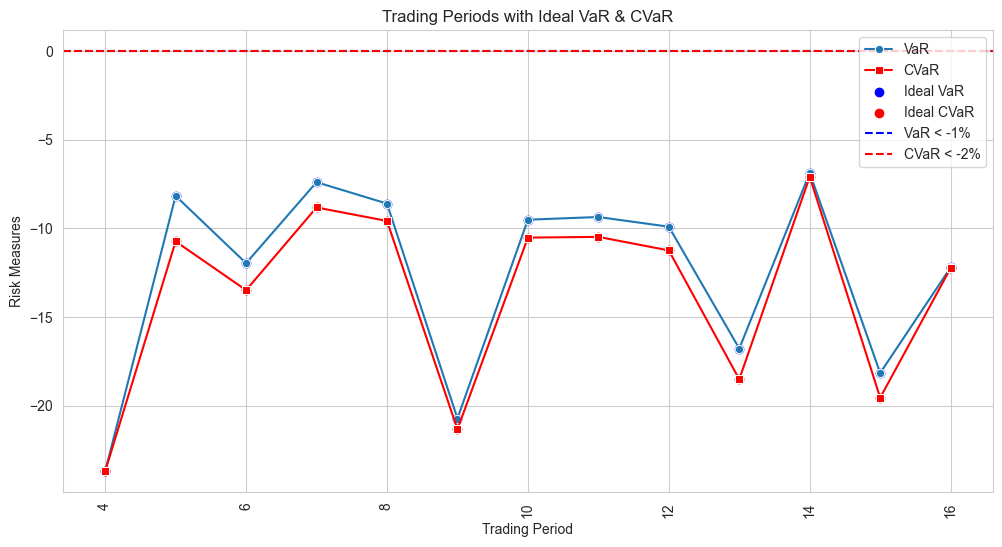

In [34]:
plt.figure(figsize=(12, 6))
sns.lineplot(x=grouped.index, y=grouped["avg_VaR"], marker="o", label="VaR")
sns.lineplot(x=grouped.index, y=grouped["avg_CVaR"], marker="s", label="CVaR", color="red")
plt.scatter(ideal_risk_periods, grouped.loc[ideal_risk_periods, "avg_VaR"], color="blue", label="Ideal VaR")
plt.scatter(ideal_risk_periods, grouped.loc[ideal_risk_periods, "avg_CVaR"], color="red", label="Ideal CVaR")
plt.xlabel("Trading Period")
plt.ylabel("Risk Measures")
plt.axhline(var_threshold, color='blue', linestyle='--', label="VaR < -1%")
plt.axhline(cvar_threshold, color='red', linestyle='--', label="CVaR < -2%")
plt.title("Trading Periods with Ideal VaR & CVaR")
plt.legend()
plt.xticks(rotation=90)
plt.show()
